# Predicción de Vulnerabilidades en Commits de GitHub

**Descripción General** <br>
Este laboratorio utiliza técnicas de Machine Learning para analizar commits de GitHub y predecir:
- **Clasificación Binaria:** Si un código es seguro o vulnerable
- **Clasificación Multiclase:** El tipo específico de vulnerabilidad

***Para ejecutar el proyecto:***
1. Ejecutar celdas en orden: Ejecutar cada celda secuencialmente
2. Ver resultados intermedios: Cada celda muestra progreso y resultados
3. Modificar parámetros: Puede ajustar el tamaño del dataset en Celda 2, funcion ***generate_vulnerability_dataset***
4. Probar con nuevos datos: Use la función load_and_predict() con sus propios datos

## Importación de Librerías
Importamos todas las librerías necesarias para el proyecto:
- pandas y numpy para manipulación de datos
- sklearn para machine learning y preprocesamiento
- xgboost como algoritmo avanzado
- matplotlib y seaborn para visualizaciones

In [ ]:
# Importación de librerías esenciales
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import random

# Machine Learning
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score

# XGBoost
import xgboost as xgb

# Utilidades
import joblib
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

## Generación del Dataset Sintético
Esta función crea un dataset sintético realista que simula commits de GitHub con:
- Características técnicas (líneas de código, complejidad, etc.)
- Patrones de seguridad específicos por lenguaje
- Historial de desarrolladores
- Etiquetas de vulnerabilidad basadas en OWASP Top 10

In [ ]:
def generate_vulnerability_dataset(n_samples=3000):
    """
    Genera un dataset sintético de commits de GitHub con características
    de seguridad para clasificación de vulnerabilidades

    Returns:
    pandas.DataFrame: Dataset con características de commits y etiquetas de seguridad
    """

    # Configuración reproducible
    np.random.seed(42)
    random.seed(42)

    # Lenguajes de programación comunes en GitHub
    languages = ['JavaScript', 'Python', 'Java', 'C++', 'C', 'PHP', 'Ruby', 'Go', 'Rust']

    # Tipos de vulnerabilidad basados en OWASP Top 10
    vulnerability_types = [
        'SQL_Injection', 'XSS', 'Buffer_Overflow', 'Insecure_Authentication',
        'Path_Traversal', 'Command_Injection', 'XXE', 'Deserialization',
        'Cryptographic_Weakness', 'Secure', 'Secure'  # Doble peso para 'Secure'
    ]

    # Palabras clave en mensajes de commit por tipo de vulnerabilidad
    vulnerability_keywords = {
        'SQL_Injection': ['sql', 'query', 'database', 'escape', 'parameterize', 'orm'],
        'XSS': ['html', 'script', 'escape', 'sanitize', 'dom', 'innerhtml'],
        'Buffer_Overflow': ['buffer', 'memory', 'alloc', 'size', 'length', 'boundary'],
        'Insecure_Authentication': ['auth', 'password', 'token', 'session', 'cookie', 'jwt'],
        'Path_Traversal': ['path', 'file', 'directory', 'traverse', 'upload'],
        'Command_Injection': ['command', 'exec', 'system', 'shell', 'subprocess'],
        'XXE': ['xml', 'external', 'entity', 'parser'],
        'Deserialization': ['serialize', 'deserialize', 'json', 'yaml', 'pickle'],
        'Cryptographic_Weakness': ['crypto', 'encrypt', 'hash', 'salt', 'iv', 'key'],
        'Secure': ['refactor', 'optimize', 'feature', 'documentation', 'test', 'style']
    }

    data = []

    for i in range(n_samples):
        # Características básicas del commit
        language = random.choice(languages)
        vulnerability_type = random.choice(vulnerability_types)

        # Determinar si es vulnerable basado en el tipo
        is_vulnerable = 1 if vulnerability_type != 'Secure' else 0

        # Características técnicas del commit
        lines_added = np.random.poisson(50)  # Número de líneas agregadas
        lines_deleted = np.random.poisson(20)  # Número de líneas eliminadas
        files_changed = np.random.poisson(3)  # Archivos modificados

        # Métricas de complejidad (dependen del lenguaje)
        complexity_factors = {
            'JavaScript': (15, 8), 'Python': (12, 6), 'Java': (20, 10),
            'C++': (25, 12), 'C': (28, 15), 'PHP': (18, 9),
            'Ruby': (14, 7), 'Go': (16, 8), 'Rust': (22, 11)
        }

        base_complexity, complexity_std = complexity_factors[language]
        cyclomatic_complexity = max(1, int(np.random.normal(base_complexity, complexity_std)))

        # Métricas de seguridad específicas por lenguaje
        security_metrics = {
            'JavaScript': {'has_input_validation': 0.3, 'has_escape_functions': 0.4},
            'Python': {'has_input_validation': 0.5, 'has_escape_functions': 0.3},
            'Java': {'has_input_validation': 0.6, 'has_escape_functions': 0.5},
            'C++': {'has_input_validation': 0.4, 'has_escape_functions': 0.2},
            'C': {'has_input_validation': 0.2, 'has_escape_functions': 0.1},
            'PHP': {'has_input_validation': 0.3, 'has_escape_functions': 0.3},
            'Ruby': {'has_input_validation': 0.5, 'has_escape_functions': 0.4},
            'Go': {'has_input_validation': 0.7, 'has_escape_functions': 0.6},
            'Rust': {'has_input_validation': 0.8, 'has_escape_functions': 0.7}
        }

        metrics = security_metrics[language]
        has_input_validation = 1 if random.random() < metrics['has_input_validation'] else 0
        has_escape_functions = 1 if random.random() < metrics['has_escape_functions'] else 0

        # Patrones de código riesgosos (dependen del tipo de vulnerabilidad)
        risky_patterns = {
            'SQL_Injection': {'raw_queries': 0.8, 'string_concatenation': 0.7},
            'XSS': {'inner_html': 0.9, 'eval_usage': 0.6},
            'Buffer_Overflow': {'fixed_size_buffers': 0.8, 'no_bounds_check': 0.9},
            'Insecure_Authentication': {'hardcoded_credentials': 0.7, 'weak_hashing': 0.6},
            'Path_Traversal': {'user_input_paths': 0.8, 'no_path_validation': 0.7},
            'Command_Injection': {'system_calls': 0.9, 'user_input_commands': 0.8},
            'XXE': {'xml_parsing': 0.9, 'external_entities': 0.7},
            'Deserialization': {'untrusted_deserialization': 0.8, 'no_validation': 0.6},
            'Cryptographic_Weakness': {'weak_crypto': 0.7, 'hardcoded_keys': 0.6},
            'Secure': {'raw_queries': 0.1, 'string_concatenation': 0.1}
        }

        pattern_weights = risky_patterns[vulnerability_type]
        has_raw_queries = 1 if random.random() < pattern_weights.get('raw_queries', 0.1) else 0
        has_string_concatenation = 1 if random.random() < pattern_weights.get('string_concatenation', 0.1) else 0
        has_inner_html = 1 if random.random() < pattern_weights.get('inner_html', 0.1) else 0

        # Historial del desarrollador
        developer_experience = np.random.normal(3, 1)  # Años de experiencia
        previous_vulnerabilities = np.random.poisson(0.5) if is_vulnerable else np.random.poisson(0.1)

        # Tamaño del cambio (proxy para riesgo)
        change_size = lines_added + lines_deleted
        risk_factor = min(1.0, change_size / 200)  # Normalizado

        # Generar mensaje de commit realista
        commit_message_keywords = random.sample(
            vulnerability_keywords[vulnerability_type],
            k=min(3, len(vulnerability_keywords[vulnerability_type]))
        )
        commit_message = f"Fix: {', '.join(commit_message_keywords)} issues"

        data.append({
            'commit_id': f"commit_{i:06d}",
            'language': language,
            'vulnerability_type': vulnerability_type,
            'is_vulnerable': is_vulnerable,
            'lines_added': lines_added,
            'lines_deleted': lines_deleted,
            'files_changed': files_changed,
            'cyclomatic_complexity': cyclomatic_complexity,
            'has_input_validation': has_input_validation,
            'has_escape_functions': has_escape_functions,
            'has_raw_queries': has_raw_queries,
            'has_string_concatenation': has_string_concatenation,
            'has_inner_html': has_inner_html,
            'developer_experience': max(0.1, developer_experience),
            'previous_vulnerabilities': previous_vulnerabilities,
            'change_size': change_size,
            'risk_factor': risk_factor,
            'commit_message': commit_message,
            'timestamp': datetime.now() - timedelta(days=random.randint(0, 365))
        })

    return pd.DataFrame(data)

# Generar el dataset
print("🔄 Generando dataset de vulnerabilidades...")
df = generate_vulnerability_dataset(3000)
print(f"Dataset generado: {df.shape[0]} filas, {df.shape[1]} columnas")

🔄 Generando dataset de vulnerabilidades...
Dataset generado: 3000 filas, 19 columnas


---
## Análisis Exploratorio de Datos (EDA)
Explicación: El EDA nos ayuda a:
- Entender la distribución de los datos
- Identificar relaciones entre variables
- Detectar posibles problemas de balance en las clases
- Validar la calidad del dataset generado

### Análisis Inicial del Dataset

In [ ]:
# Análisis inicial del dataset
print("ANÁLISIS EXPLORATORIO DE DATOS")
print("=" * 50)

print("\nEstructura del Dataset:")
print(f"Dimensiones: {df.shape}")
print(f"\nPrimeras 5 filas:")
display(df.head())

print(f"\nInformación de columnas:")
print(df.info())

print(f"\nEstadísticas descriptivas:")
print(df.describe())

print(f"\nDistribución de variables clave:")
print(f"Lenguajes: \n{df['language'].value_counts()}")
print(f"\nTipos de vulnerabilidad: \n{df['vulnerability_type'].value_counts()}")
print(f"\nBalance vulnerable/seguro: \n{df['is_vulnerable'].value_counts()}")
print(f"Proporción vulnerable: {df['is_vulnerable'].mean():.2%}")

ANÁLISIS EXPLORATORIO DE DATOS

Estructura del Dataset:
Dimensiones: (3000, 19)

Primeras 5 filas:


,commit_id,language,vulnerability_type,is_vulnerable,lines_added,lines_deleted,files_changed,cyclomatic_complexity,has_input_validation,has_escape_functions,has_raw_queries,has_string_concatenation,has_inner_html,developer_experience,previous_vulnerabilities,change_size,risk_factor,commit_message,timestamp
0,commit_000000,Python,SQL_Injection,1,47,23,1,21,0,1,1,1,0,3.767435,0,70,0.350,"Fix: parameterize, sql, escape issues",2025-11-04 15:38:37.511726
1,commit_000001,JavaScript,XSS,1,43,15,3,11,1,0,1,0,1,2.257593,0,58,0.290,"Fix: dom, sanitize, script issues",2025-04-05 15:38:37.511821
2,commit_000002,C,SQL_Injection,1,49,16,1,10,0,0,1,1,0,3.375698,0,65,0.325,"Fix: database, sql, parameterize issues",2025-05-10 15:38:37.511874
3,commit_000003,Python,Command_Injection,1,57,13,2,16,0,0,0,0,0,1.779156,0,70,0.350,"Fix: shell, command, system issues",2025-06-23 15:38:37.511916
4,commit_000004,PHP,Secure,0,50,27,2,16,1,1,0,0,0,2.698896,0,77,0.385,"Fix: optimize, refactor, documentation issues",2025-07-01 15:38:37.511972



Información de columnas:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3000 entries, 0 to 2999
Data columns (total 19 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   commit_id                 3000 non-null   object        
 1   language                  3000 non-null   object        
 2   vulnerability_type        3000 non-null   object        
 3   is_vulnerable             3000 non-null   int64         
 4   lines_added               3000 non-null   int64         
 5   lines_deleted             3000 non-null   int64         
 6   files_changed             3000 non-null   int64         
 7   cyclomatic_complexity     3000 non-null   int64         
 8   has_input_validation      3000 non-null   int64         
 9   has_escape_functions      3000 non-null   int64         
 10  has_raw_queries           3000 non-null   int64         
 11  has_string_concatenation  3000 non-null   int64         

### Visualizaciones del Dataset

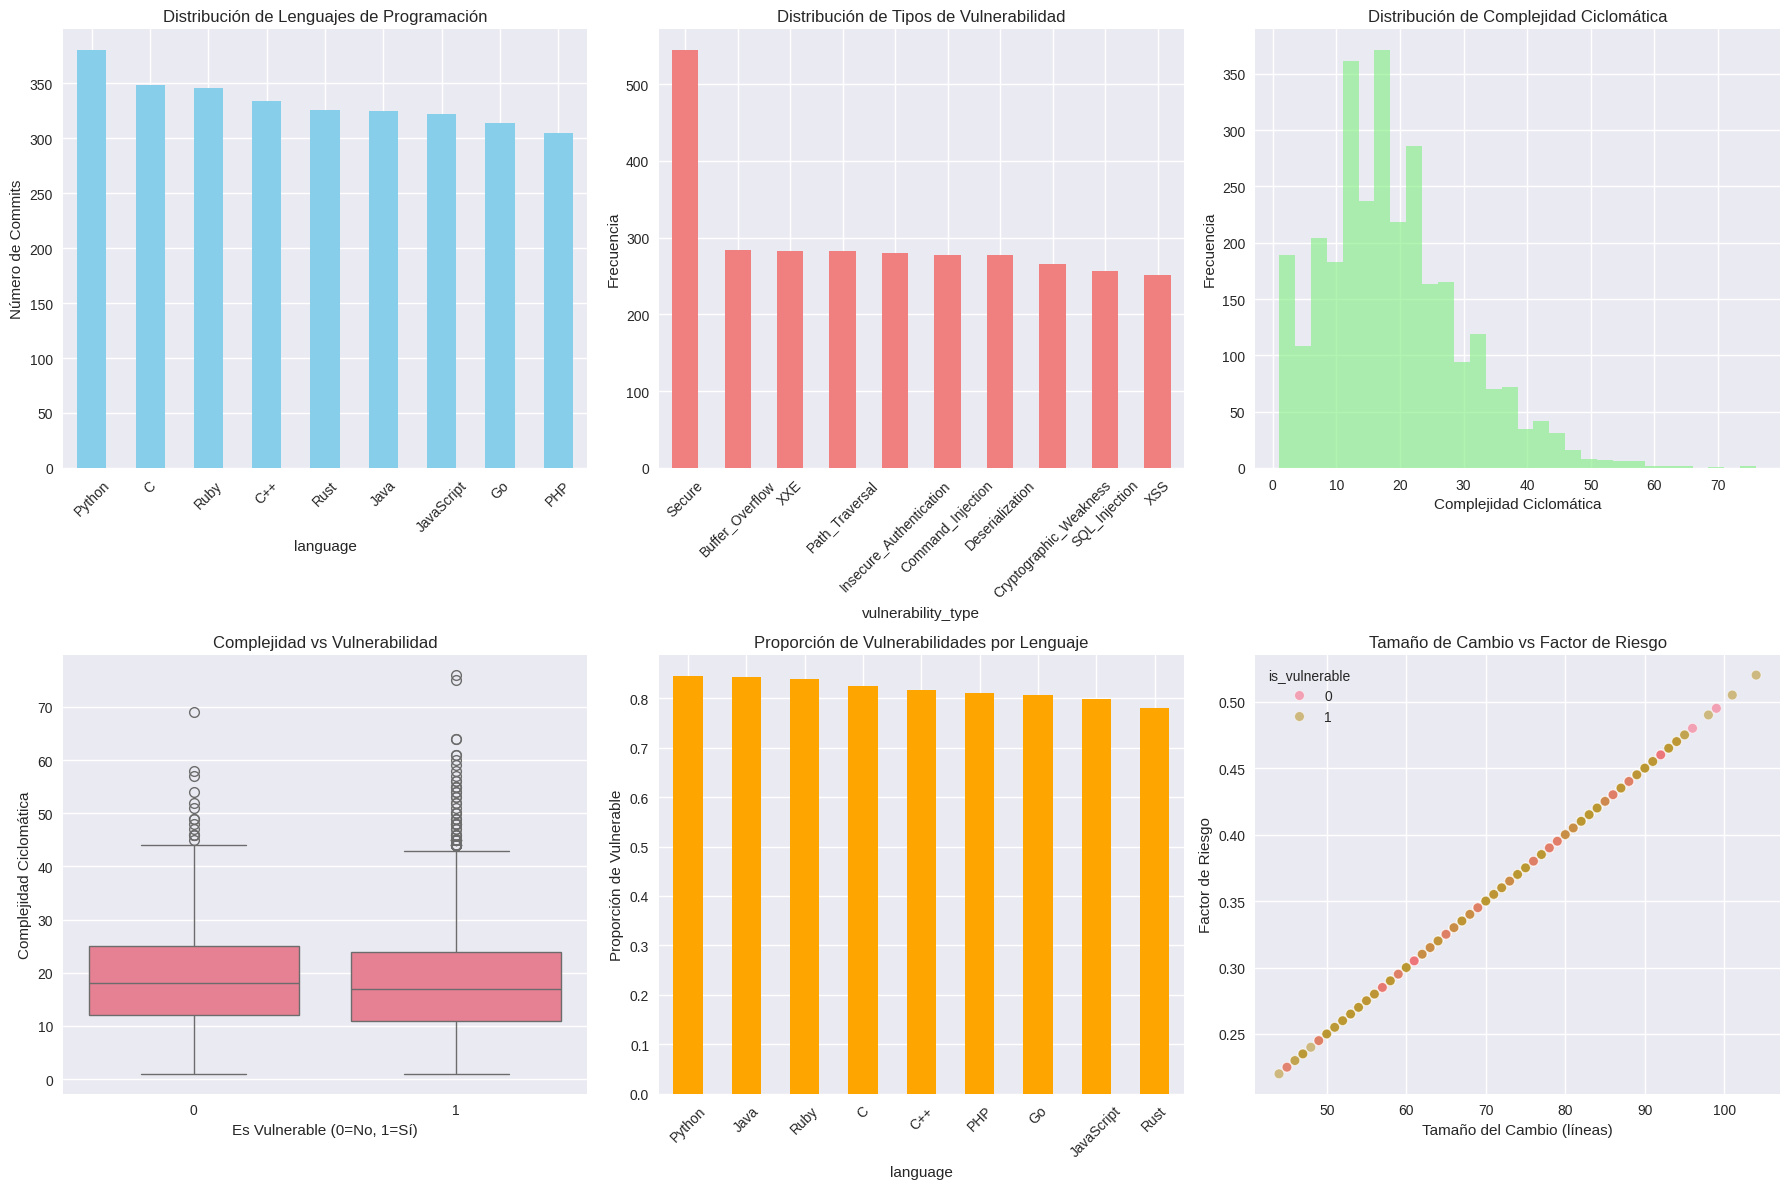


🔗 Matriz de Correlaciones:


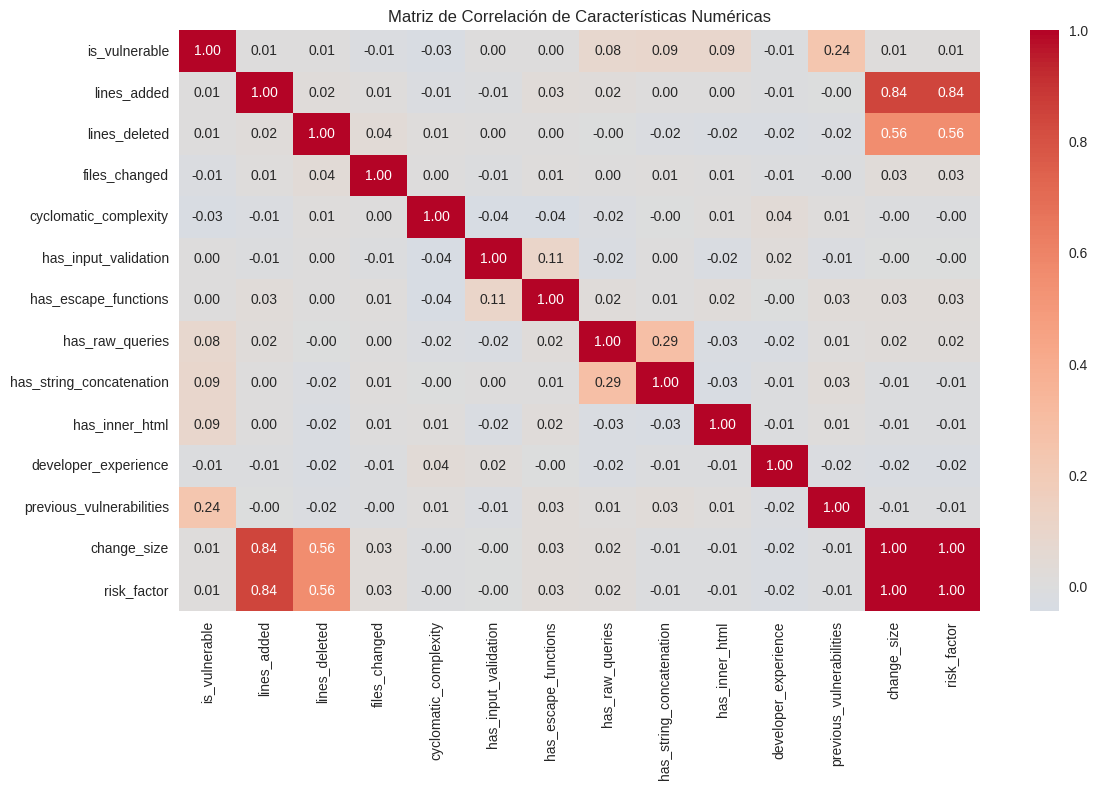

In [ ]:
# Visualización de la distribución de datos
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# 1. Distribución de lenguajes
df['language'].value_counts().plot(kind='bar', ax=axes[0,0], color='skyblue')
axes[0,0].set_title('Distribución de Lenguajes de Programación')
axes[0,0].tick_params(axis='x', rotation=45)
axes[0,0].set_ylabel('Número de Commits')

# 2. Distribución de tipos de vulnerabilidad
df['vulnerability_type'].value_counts().plot(kind='bar', ax=axes[0,1], color='lightcoral')
axes[0,1].set_title('Distribución de Tipos de Vulnerabilidad')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].set_ylabel('Frecuencia')

# 3. Distribución de complejidad ciclomática
df['cyclomatic_complexity'].hist(bins=30, ax=axes[0,2], color='lightgreen', alpha=0.7)
axes[0,2].set_title('Distribución de Complejidad Ciclomática')
axes[0,2].set_xlabel('Complejidad Ciclomática')
axes[0,2].set_ylabel('Frecuencia')

# 4. Relación entre complejidad y vulnerabilidad
sns.boxplot(data=df, x='is_vulnerable', y='cyclomatic_complexity', ax=axes[1,0])
axes[1,0].set_title('Complejidad vs Vulnerabilidad')
axes[1,0].set_xlabel('Es Vulnerable (0=No, 1=Sí)')
axes[1,0].set_ylabel('Complejidad Ciclomática')

# 5. Vulnerabilidades por lenguaje
vuln_by_lang = df.groupby('language')['is_vulnerable'].mean().sort_values(ascending=False)
vuln_by_lang.plot(kind='bar', ax=axes[1,1], color='orange')
axes[1,1].set_title('Proporción de Vulnerabilidades por Lenguaje')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].set_ylabel('Proporción de Vulnerable')

# 6. Tamaño de cambio vs vulnerabilidad
sns.scatterplot(data=df, x='change_size', y='risk_factor', hue='is_vulnerable',
                alpha=0.6, ax=axes[1,2])
axes[1,2].set_title('Tamaño de Cambio vs Factor de Riesgo')
axes[1,2].set_xlabel('Tamaño del Cambio (líneas)')
axes[1,2].set_ylabel('Factor de Riesgo')

plt.tight_layout()
plt.show()

# Análisis de correlaciones
print("\n🔗 Matriz de Correlaciones:")
numeric_cols = df.select_dtypes(include=[np.number]).columns
plt.figure(figsize=(12, 8))
sns.heatmap(df[numeric_cols].corr(), annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Matriz de Correlación de Características Numéricas')
plt.tight_layout()
plt.show()

---
## Preprocesamiento de Datos
**Preparación de Características**<br>
Explicación: Esta función:
- Separa características de etiquetas
- Codifica las etiquetas de texto a numéricas para modelos de ML
- Define el preprocesador para diferentes tipos de características
- Aplica escalado a numéricas y one-hot encoding a categóricas

In [ ]:
def prepare_features(df):
    """
    Prepara las características para el modelado

    Returns:
    tuple: (X, y_binary, y_multiclass, preprocessor, label_encoder)
    """
    print("🔄 Preparando características para modelado...")

    # Separar características y targets
    X = df.drop(['commit_id', 'vulnerability_type', 'is_vulnerable', 'commit_message', 'timestamp'], axis=1)
    y_binary = df['is_vulnerable']  # Clasificación binaria
    y_multiclass = df['vulnerability_type']  # Clasificación multiclase

    # Codificar etiquetas multiclase a números
    label_encoder = LabelEncoder()
    y_multiclass_encoded = label_encoder.fit_transform(y_multiclass)

    print("Mapeo de clases de vulnerabilidad:")
    for i, class_name in enumerate(label_encoder.classes_):
        print(f"  {i}: {class_name}")

    # Definir transformadores
    numeric_features = [
        'lines_added', 'lines_deleted', 'files_changed', 'cyclomatic_complexity',
        'developer_experience', 'previous_vulnerabilities', 'change_size', 'risk_factor'
    ]

    categorical_features = ['language']

    binary_features = [
        'has_input_validation', 'has_escape_functions', 'has_raw_queries',
        'has_string_concatenation', 'has_inner_html'
    ]

    preprocessor = ColumnTransformer(
        transformers=[
            ('num', StandardScaler(), numeric_features),
            ('cat', OneHotEncoder(drop='first', sparse_output=False), categorical_features),
            ('bin', 'passthrough', binary_features)
        ]
    )

    print("Características preparadas exitosamente")
    return X, y_binary, y_multiclass_encoded, preprocessor, label_encoder

# Preparar los datos
X, y_binary, y_multiclass_encoded, preprocessor, label_encoder = prepare_features(df)

🔄 Preparando características para modelado...
Mapeo de clases de vulnerabilidad:
  0: Buffer_Overflow
  1: Command_Injection
  2: Cryptographic_Weakness
  3: Deserialization
  4: Insecure_Authentication
  5: Path_Traversal
  6: SQL_Injection
  7: Secure
  8: XSS
  9: XXE
Características preparadas exitosamente


**División de Datos**

In [ ]:
# Dividir en conjuntos de entrenamiento y prueba
print("🔄 Dividiendo datos en train y test...")

# Para clasificación binaria
X_train_bin, X_test_bin, y_train_bin, y_test_bin = train_test_split(
    X, y_binary, test_size=0.2, random_state=42, stratify=y_binary
)

# Para clasificación multiclase
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(
    X, y_multiclass_encoded, test_size=0.2, random_state=42, stratify=y_multiclass_encoded
)

print("✅ Datos divididos exitosamente:")
print(f"📊 Conjunto de entrenamiento binario: {X_train_bin.shape}")
print(f"📊 Conjunto de prueba binario: {X_test_bin.shape}")
print(f"🎯 Conjunto de entrenamiento multiclase: {X_train_multi.shape}")
print(f"🎯 Conjunto de prueba multiclase: {X_test_multi.shape}")

# Verificar balance de clases
print(f"\n⚖️ Balance en entrenamiento binario:")
print(pd.Series(y_train_bin).value_counts(normalize=True))
print(f"\n⚖️ Balance en entrenamiento multiclase:")
unique, counts = np.unique(y_train_multi, return_counts=True)
for cls, count in zip(unique, counts):
    class_name = label_encoder.inverse_transform([cls])[0]
    print(f"  {class_name}: {count/len(y_train_multi):.2%}")

🔄 Dividiendo datos en train y test...
✅ Datos divididos exitosamente:
📊 Conjunto de entrenamiento binario: (2400, 14)
📊 Conjunto de prueba binario: (600, 14)
🎯 Conjunto de entrenamiento multiclase: (2400, 14)
🎯 Conjunto de prueba multiclase: (600, 14)

⚖️ Balance en entrenamiento binario:
is_vulnerable
1    0.81875
0    0.18125
Name: proportion, dtype: float64

⚖️ Balance en entrenamiento multiclase:
  Buffer_Overflow: 9.46%
  Command_Injection: 9.21%
  Cryptographic_Weakness: 8.88%
  Deserialization: 9.25%
  Insecure_Authentication: 9.33%
  Path_Traversal: 9.42%
  SQL_Injection: 8.54%
  Secure: 18.12%
  XSS: 8.38%
  XXE: 9.42%


---
### Entrenamiento de Modelos
Explicación: Entrenamos múltiples algoritmos para:
- Binario: Random Forest, Logistic Regression, SVM, XGBoost
- Multiclase: Random Forest y XGBoost. <br>
  
Cada modelo se evalúa con métricas estándar de clasificación.
#### Clasificación Binaria (Seguro/Vulnerable)

In [ ]:
# Modelos para clasificación binaria
print("🔧 Entrenando modelos de clasificación binaria...")

binary_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Logistic Regression': LogisticRegression(random_state=42, max_iter=1000),
    'SVM': SVC(random_state=42, probability=True),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

binary_results = {}

for name, model in binary_models.items():
    print(f"🔄 Entrenando {name}...")

    # Crear pipeline
    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Entrenar modelo
    pipeline.fit(X_train_bin, y_train_bin)

    # Predecir
    y_pred = pipeline.predict(X_test_bin)
    y_pred_proba = pipeline.predict_proba(X_test_bin)[:, 1]

    # Evaluar
    accuracy = accuracy_score(y_test_bin, y_pred)
    binary_results[name] = {
        'model': pipeline,
        'accuracy': accuracy,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"✅ {name} - Accuracy: {accuracy:.4f}")
    print(classification_report(y_test_bin, y_pred))
    print("─" * 50)

# Mostrar comparación de modelos binarios
print("\n🏆 COMPARACIÓN DE MODELOS BINARIOS:")
binary_comparison = pd.DataFrame({
    'Modelo': list(binary_results.keys()),
    'Accuracy': [result['accuracy'] for result in binary_results.values()]
}).sort_values('Accuracy', ascending=False)

print(binary_comparison)

🔧 Entrenando modelos de clasificación binaria...
🔄 Entrenando Random Forest...
✅ Random Forest - Accuracy: 0.8033
              precision    recall  f1-score   support

           0       0.15      0.02      0.03       109
           1       0.82      0.98      0.89       491

    accuracy                           0.80       600
   macro avg       0.49      0.50      0.46       600
weighted avg       0.70      0.80      0.73       600

──────────────────────────────────────────────────
🔄 Entrenando Logistic Regression...
✅ Logistic Regression - Accuracy: 0.8183
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       109
           1       0.82      1.00      0.90       491

    accuracy                           0.82       600
   macro avg       0.41      0.50      0.45       600
weighted avg       0.67      0.82      0.74       600

──────────────────────────────────────────────────
🔄 Entrenando SVM...
✅ SVM - Accuracy: 0.8183
        

#### Clasificación Multiclase (Tipo de Vulnerabilidad)

In [ ]:
# Modelos para clasificación multiclase
print("🔧 Entrenando modelos de clasificación multiclase...")

multi_models = {
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss')
}

multi_results = {}

for name, model in multi_models.items():
    print(f"🔄 Entrenando {name}...")

    pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', model)
    ])

    # Entrenar modelo
    pipeline.fit(X_train_multi, y_train_multi)

    # Predecir
    y_pred = pipeline.predict(X_test_multi)
    y_pred_proba = pipeline.predict_proba(X_test_multi)

    # Evaluar
    accuracy = accuracy_score(y_test_multi, y_pred)
    multi_results[name] = {
        'model': pipeline,
        'accuracy': accuracy,
        'predictions': y_pred,
        'probabilities': y_pred_proba,
        'label_encoder': label_encoder
    }

    print(f"✅ {name} - Accuracy: {accuracy:.4f}")

    # Convertir números de vuelta a nombres para el reporte
    y_test_names = label_encoder.inverse_transform(y_test_multi)
    y_pred_names = label_encoder.inverse_transform(y_pred)

    print(classification_report(y_test_names, y_pred_names))
    print("─" * 50)

# Mostrar comparación de modelos multiclase
print("\n🏆 COMPARACIÓN DE MODELOS MULTICLASE:")
multi_comparison = pd.DataFrame({
    'Modelo': list(multi_results.keys()),
    'Accuracy': [result['accuracy'] for result in multi_results.values()]
}).sort_values('Accuracy', ascending=False)

print(multi_comparison)

🔧 Entrenando modelos de clasificación multiclase...
🔄 Entrenando Random Forest...
✅ Random Forest - Accuracy: 0.2650
                         precision    recall  f1-score   support

        Buffer_Overflow       0.12      0.05      0.07        57
      Command_Injection       0.08      0.07      0.08        56
 Cryptographic_Weakness       0.08      0.04      0.05        53
        Deserialization       0.08      0.05      0.06        55
Insecure_Authentication       0.18      0.12      0.15        56
         Path_Traversal       0.04      0.02      0.02        56
          SQL_Injection       0.55      0.79      0.65        52
                 Secure       0.28      0.48      0.35       109
                    XSS       0.49      0.82      0.61        50
                    XXE       0.10      0.09      0.10        56

               accuracy                           0.27       600
              macro avg       0.20      0.25      0.21       600
           weighted avg       0.20  

---
## Evaluación y Visualización
#### Matrices de Confusión

📈 Visualizando matrices de confusión...


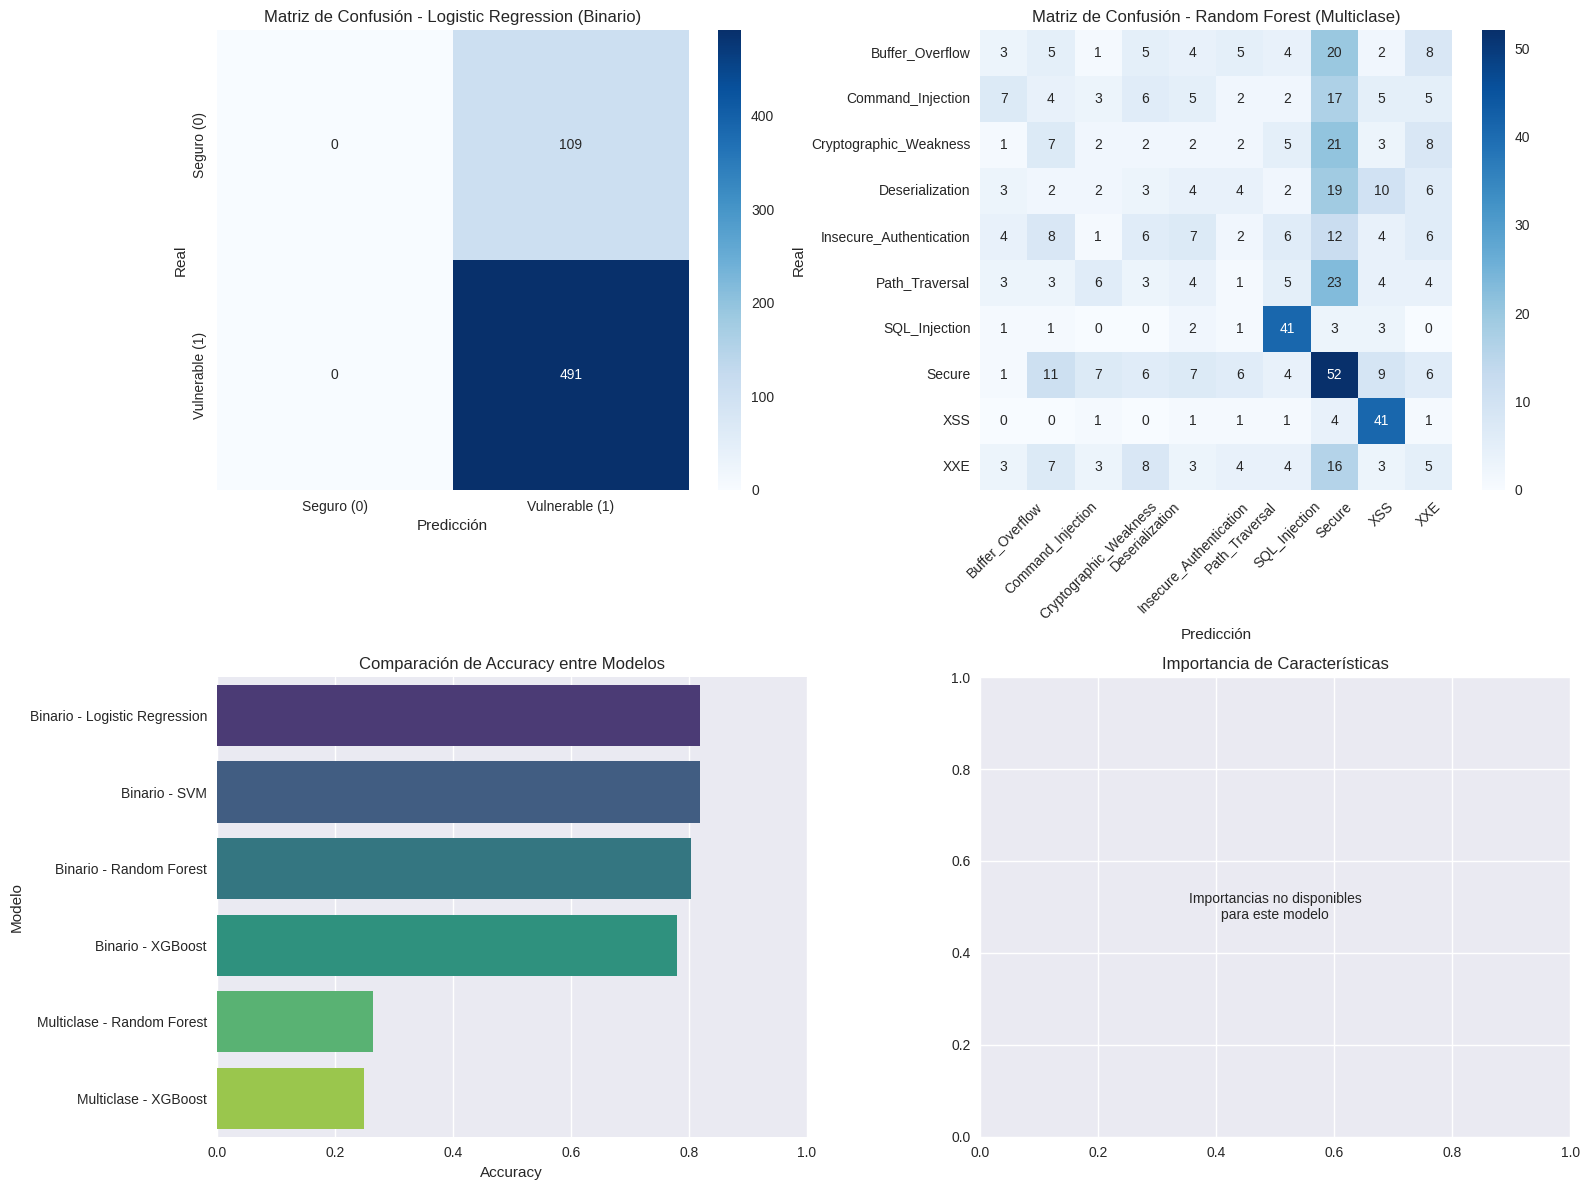

✅ Visualizaciones completadas


In [ ]:
# Corrección de matrices de confusión
print("📈 Visualizando matrices de confusión...")

fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# 1. Matriz de confusión para el mejor modelo binario
best_binary_name = binary_comparison.iloc[0]['Modelo']
best_binary_result = binary_results[best_binary_name]

# Calcular matriz de confusión binaria
cm_binary = confusion_matrix(y_test_bin, best_binary_result['predictions'])

# Visualizar matriz binaria
sns.heatmap(cm_binary, annot=True, fmt='d', cmap='Blues', ax=axes[0,0],
            xticklabels=['Seguro (0)', 'Vulnerable (1)'],
            yticklabels=['Seguro (0)', 'Vulnerable (1)'])
axes[0,0].set_title(f'Matriz de Confusión - {best_binary_name} (Binario)')
axes[0,0].set_xlabel('Predicción')
axes[0,0].set_ylabel('Real')

# 2. Matriz de confusión para el mejor modelo multiclase
best_multi_name = multi_comparison.iloc[0]['Modelo']
best_multi_result = multi_results[best_multi_name]

# Convertir etiquetas numéricas a nombres para la matriz
y_test_multi_names = label_encoder.inverse_transform(y_test_multi)
y_pred_multi_names = label_encoder.inverse_transform(best_multi_result['predictions'])
class_names = label_encoder.classes_

# Calcular matriz de confusión multiclase
cm_multi = confusion_matrix(y_test_multi_names, y_pred_multi_names, labels=class_names)

# Visualizar matriz multiclase
sns.heatmap(cm_multi, annot=True, fmt='d', cmap='Blues', ax=axes[0,1],
            xticklabels=class_names,
            yticklabels=class_names)
axes[0,1].set_title(f'Matriz de Confusión - {best_multi_name} (Multiclase)')
axes[0,1].set_xlabel('Predicción')
axes[0,1].set_ylabel('Real')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].tick_params(axis='y', rotation=0)

# 3. Comparación de accuracy entre modelos
models_combined = {
    **{f"Binario - {k}": v['accuracy'] for k, v in binary_results.items()},
    **{f"Multiclase - {k}": v['accuracy'] for k, v in multi_results.items()}
}

models_df = pd.DataFrame({
    'Modelo': list(models_combined.keys()),
    'Accuracy': list(models_combined.values())
}).sort_values('Accuracy', ascending=False)

sns.barplot(data=models_df, x='Accuracy', y='Modelo', ax=axes[1,0], palette='viridis')
axes[1,0].set_title('Comparación de Accuracy entre Modelos')
axes[1,0].set_xlim(0, 1)

# 4. Importancia de características - CORREGIDO
try:
    best_model = binary_results[best_binary_name]['model']

    # Obtener nombres de características del preprocesador
    feature_names = []

    # Características numéricas
    numeric_features = [
        'lines_added', 'lines_deleted', 'files_changed', 'cyclomatic_complexity',
        'developer_experience', 'previous_vulnerabilities', 'change_size', 'risk_factor'
    ]
    feature_names.extend(numeric_features)

    # Características categóricas (one-hot encoded)
    if hasattr(preprocessor.named_transformers_['cat'], 'get_feature_names_out'):
        cat_features = preprocessor.named_transformers_['cat'].get_feature_names_out(['language'])
        feature_names.extend(cat_features)
    else:
        # Fallback: nombres genéricos para características categóricas
        unique_langs = X['language'].unique()
        feature_names.extend([f'language_{lang}' for lang in unique_langs[1:]])  # Excluir primera categoría (drop='first')

    # Características binarias
    binary_features = [
        'has_input_validation', 'has_escape_functions', 'has_raw_queries',
        'has_string_concatenation', 'has_inner_html'
    ]
    feature_names.extend(binary_features)

    # Obtener importancias del modelo
    if hasattr(best_model.named_steps['classifier'], 'feature_importances_'):
        importances = best_model.named_steps['classifier'].feature_importances_

        # Asegurarse de que tenemos el mismo número de características
        min_length = min(len(importances), len(feature_names))
        importances = importances[:min_length]
        feature_names_used = feature_names[:min_length]

        feature_importance_df = pd.DataFrame({
            'feature': feature_names_used,
            'importance': importances
        }).sort_values('importance', ascending=False).head(10)

        sns.barplot(data=feature_importance_df, x='importance', y='feature', ax=axes[1,1], palette='rocket')
        axes[1,1].set_title('Top 10 Características Más Importantes')
    else:
        axes[1,1].text(0.5, 0.5, 'Importancias no disponibles\npara este modelo',
                      ha='center', va='center', transform=axes[1,1].transAxes)
        axes[1,1].set_title('Importancia de Características')

except Exception as e:
    print(f"⚠️ Error al generar importancia de características: {e}")
    axes[1,1].text(0.5, 0.5, f'Error: {str(e)}',
                  ha='center', va='center', transform=axes[1,1].transAxes)
    axes[1,1].set_title('Importancia de Características')

plt.tight_layout()
plt.show()

print("✅ Visualizaciones completadas")

#### Análisis de Características Importantes

In [ ]:
# ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES - VERSIÓN CORREGIDA
print("🔍 ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES")
print("=" * 50)

def get_feature_importance_analysis(model, preprocessor, feature_names, top_n=15):
    """
    Función robusta para analizar la importancia de características

    Args:
        model: Modelo entrenado con pipeline
        preprocessor: Preprocesador usado
        feature_names: Lista de nombres originales de características
        top_n: Número top de características a mostrar

    Returns:
        DataFrame con importancia de características
    """
    try:
        # Verificar si el modelo tiene importancias
        if not hasattr(model.named_steps['classifier'], 'feature_importances_'):
            print("⚠️ Este modelo no tiene importancias de características")
            return None

        # Obtener importancias
        importances = model.named_steps['classifier'].feature_importances_

        # Construir nombres de características del preprocesador
        final_feature_names = []

        # 1. Características numéricas (mantienen sus nombres)
        numeric_features = [
            'lines_added', 'lines_deleted', 'files_changed', 'cyclomatic_complexity',
            'developer_experience', 'previous_vulnerabilities', 'change_size', 'risk_factor'
        ]
        final_feature_names.extend(numeric_features)

        # 2. Características categóricas (OneHot Encoding)
        categorical_transformer = preprocessor.named_transformers_['cat']
        if hasattr(categorical_transformer, 'get_feature_names_out'):
            cat_features = categorical_transformer.get_feature_names_out(['language'])
            final_feature_names.extend(cat_features)
        else:
            # Fallback manual
            unique_langs = ['JavaScript', 'Python', 'Java', 'C++', 'C', 'PHP', 'Ruby', 'Go', 'Rust']
            # Excluir la primera categoría (due to drop='first')
            final_feature_names.extend([f'language_{lang}' for lang in unique_langs[1:]])

        # 3. Características binarias
        binary_features = [
            'has_input_validation', 'has_escape_functions', 'has_raw_queries',
            'has_string_concatenation', 'has_inner_html'
        ]
        final_feature_names.extend(binary_features)

        # Asegurar que tenemos la misma cantidad de características
        min_length = min(len(importances), len(final_feature_names))
        importances = importances[:min_length]
        final_feature_names = final_feature_names[:min_length]

        # Crear DataFrame
        importance_df = pd.DataFrame({
            'feature': final_feature_names,
            'importance': importances
        }).sort_values('importance', ascending=False).head(top_n)

        return importance_df

    except Exception as e:
        print(f"❌ Error en análisis de características: {e}")
        return None

# Aplicar a todos los modelos que tengan importancias
print("📊 IMPORTANCIA DE CARACTERÍSTICAS POR MODELO")

# Para modelos binarios
print("\n🔒 MODELOS BINARIOS:")
binary_importance_results = {}

for model_name, result in binary_results.items():
    print(f"\n🔹 Analizando {model_name}...")

    importance_df = get_feature_importance_analysis(
        result['model'],
        preprocessor,
        list(X.columns),
        top_n=10
    )

    if importance_df is not None:
        binary_importance_results[model_name] = importance_df
        print(f"✅ Top 5 características más importantes:")
        for idx, row in importance_df.head().iterrows():
            print(f"   {row['feature']}: {row['importance']:.4f}")
    else:
        print(f"⚠️ No se pudieron obtener importancias para {model_name}")

# Para modelos multiclase
print("\n🎯 MODELOS MULTICLASE:")
multi_importance_results = {}

for model_name, result in multi_results.items():
    print(f"\n🔹 Analizando {model_name}...")

    importance_df = get_feature_importance_analysis(
        result['model'],
        preprocessor,
        list(X.columns),
        top_n=10
    )

    if importance_df is not None:
        multi_importance_results[model_name] = importance_df
        print(f"✅ Top 5 características más importantes:")
        for idx, row in importance_df.head().iterrows():
            print(f"   {row['feature']}: {row['importance']:.4f}")
    else:
        print(f"⚠️ No se pudieron obtener importancias para {model_name}")

# Visualización de importancias
print("\n📈 VISUALIZANDO IMPORTANCIAS...")

# Seleccionar el mejor modelo para visualización detallada
if binary_importance_results:
    best_binary_model_name = max(binary_results.items(),
                                key=lambda x: x[1]['accuracy'])[0]

    if best_binary_model_name in binary_importance_results:
        best_importance_df = binary_importance_results[best_binary_model_name]

        # Crear visualización
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

        # Gráfico de barras horizontal
        sns.barplot(data=best_importance_df, x='importance', y='feature',
                   ax=ax1, palette='viridis')
        ax1.set_title(f'Importancia de Características - {best_binary_model_name}\n(Clasificación Binaria)')
        ax1.set_xlabel('Importancia')
        ax1.set_ylabel('Característica')

        # Gráfico de pie para top 5
        top_5 = best_importance_df.head(5)
        colors = plt.cm.Set3(np.linspace(0, 1, len(top_5)))
        ax2.pie(top_5['importance'], labels=top_5['feature'], autopct='%1.1f%%',
               colors=colors, startangle=90)
        ax2.set_title('Distribución de Importancia\n(Top 5 Características)')

        plt.tight_layout()
        plt.show()

        # Análisis detallado
        print(f"\n📋 ANÁLISIS DETALLADO - {best_binary_model_name}:")
        print("=" * 50)

        for idx, row in best_importance_df.iterrows():
            importance_percent = (row['importance'] / best_importance_df['importance'].sum()) * 100
            print(f"#{idx+1:2d} {row['feature']:30} {row['importance']:.4f} ({importance_percent:5.1f}%)")

    else:
        print("⚠️ No hay datos de importancia para el mejor modelo binario")
else:
    print("⚠️ No hay resultados de importancia disponibles")

🔍 ANÁLISIS DE CARACTERÍSTICAS IMPORTANTES
📊 IMPORTANCIA DE CARACTERÍSTICAS POR MODELO

🔒 MODELOS BINARIOS:

🔹 Analizando Random Forest...
✅ Top 5 características más importantes:
   developer_experience: 0.1552
   cyclomatic_complexity: 0.1207
   lines_added: 0.1038
   lines_deleted: 0.0989
   risk_factor: 0.0923

🔹 Analizando Logistic Regression...
⚠️ Este modelo no tiene importancias de características
⚠️ No se pudieron obtener importancias para Logistic Regression

🔹 Analizando SVM...
⚠️ Este modelo no tiene importancias de características
⚠️ No se pudieron obtener importancias para SVM

🔹 Analizando XGBoost...
✅ Top 5 características más importantes:
   previous_vulnerabilities: 0.2712
   has_raw_queries: 0.0840
   has_string_concatenation: 0.0645
   has_inner_html: 0.0488
   language_Go: 0.0400

🎯 MODELOS MULTICLASE:

🔹 Analizando Random Forest...
✅ Top 5 características más importantes:
   developer_experience: 0.1288
   cyclomatic_complexity: 0.1129
   lines_added: 0.0993
   lin

In [ ]:
# ANÁLISIS POR TIPO DE CARACTERÍSTICA
print("🎯 ANÁLISIS POR TIPO DE CARACTERÍSTICA")
print("=" * 40)

def analyze_feature_categories(importance_df):
    """Analiza las características por categorías"""
    if importance_df is None:
        return

    # Definir categorías
    categories = {
        'Complejidad y Tamaño': ['cyclomatic_complexity', 'change_size', 'files_changed',
                                'lines_added', 'lines_deleted'],
        'Historial Desarrollador': ['developer_experience', 'previous_vulnerabilities', 'risk_factor'],
        'Prácticas Seguras': ['has_input_validation', 'has_escape_functions'],
        'Patrones Riesgosos': ['has_raw_queries', 'has_string_concatenation', 'has_inner_html'],
        'Lenguaje': [col for col in importance_df['feature'] if col.startswith('language_')]
    }

    category_importance = {}

    for category, features in categories.items():
        category_features = importance_df[importance_df['feature'].isin(features)]
        total_importance = category_features['importance'].sum()
        category_importance[category] = {
            'total_importance': total_importance,
            'feature_count': len(category_features),
            'features': category_features.to_dict('records')
        }

    return category_importance

# Aplicar análisis al mejor modelo
if binary_importance_results and best_binary_model_name in binary_importance_results:
    best_importance_df = binary_importance_results[best_binary_model_name]
    category_analysis = analyze_feature_categories(best_importance_df)

    if category_analysis:
        print(f"\n📊 DISTRIBUCIÓN POR CATEGORÍAS - {best_binary_model_name}:")

        # Calcular porcentajes
        total_importance = best_importance_df['importance'].sum()

        for category, data in category_analysis.items():
            percentage = (data['total_importance'] / total_importance) * 100
            print(f"\n🔹 {category}:")
            print(f"   Importancia total: {data['total_importance']:.4f} ({percentage:.1f}%)")
            print(f"   Número de características: {data['feature_count']}")

            if data['features']:
                print("   Características incluidas:")
                for feature in data['features']:
                    feat_percentage = (feature['importance'] / total_importance) * 100
                    print(f"     - {feature['feature']}: {feature['importance']:.4f} ({feat_percentage:.1f}%)")

# Visualización de categorías
if binary_importance_results and best_binary_model_name in binary_importance_results:
    category_analysis = analyze_feature_categories(best_importance_df)

    if category_analysis:
        # Preparar datos para visualización
        categories = list(category_analysis.keys())
        importances = [data['total_importance'] for data in category_analysis.values()]
        percentages = [(imp / total_importance) * 100 for imp in importances]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Gráfico de barras
        bars = ax1.bar(categories, importances, color=plt.cm.Pastel1(range(len(categories))))
        ax1.set_title('Importancia por Categoría de Característica')
        ax1.set_ylabel('Importancia Total')
        ax1.tick_params(axis='x', rotation=45)

        # Añadir valores en las barras
        for bar, percentage in zip(bars, percentages):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{percentage:.1f}%', ha='center', va='bottom')

        # Gráfico de pie
        ax2.pie(importances, labels=categories, autopct='%1.1f%%', startangle=90,
               colors=plt.cm.Set3(np.linspace(0, 1, len(categories))))
        ax2.set_title('Distribución de Importancia por Categoría')

        plt.tight_layout()
        plt.show()

🎯 ANÁLISIS POR TIPO DE CARACTERÍSTICA


In [ ]:
# ANÁLISIS POR TIPO DE CARACTERÍSTICA
print("🎯 ANÁLISIS POR TIPO DE CARACTERÍSTICA")
print("=" * 40)

def analyze_feature_categories(importance_df):
    """Analiza las características por categorías"""
    if importance_df is None:
        return

    # Definir categorías
    categories = {
        'Complejidad y Tamaño': ['cyclomatic_complexity', 'change_size', 'files_changed',
                                'lines_added', 'lines_deleted'],
        'Historial Desarrollador': ['developer_experience', 'previous_vulnerabilities', 'risk_factor'],
        'Prácticas Seguras': ['has_input_validation', 'has_escape_functions'],
        'Patrones Riesgosos': ['has_raw_queries', 'has_string_concatenation', 'has_inner_html'],
        'Lenguaje': [col for col in importance_df['feature'] if col.startswith('language_')]
    }

    category_importance = {}

    for category, features in categories.items():
        category_features = importance_df[importance_df['feature'].isin(features)]
        total_importance = category_features['importance'].sum()
        category_importance[category] = {
            'total_importance': total_importance,
            'feature_count': len(category_features),
            'features': category_features.to_dict('records')
        }

    return category_importance

# Aplicar análisis al mejor modelo
if binary_importance_results and best_binary_model_name in binary_importance_results:
    best_importance_df = binary_importance_results[best_binary_model_name]
    category_analysis = analyze_feature_categories(best_importance_df)

    if category_analysis:
        print(f"\n📊 DISTRIBUCIÓN POR CATEGORÍAS - {best_binary_model_name}:")

        # Calcular porcentajes
        total_importance = best_importance_df['importance'].sum()

        for category, data in category_analysis.items():
            percentage = (data['total_importance'] / total_importance) * 100
            print(f"\n🔹 {category}:")
            print(f"   Importancia total: {data['total_importance']:.4f} ({percentage:.1f}%)")
            print(f"   Número de características: {data['feature_count']}")

            if data['features']:
                print("   Características incluidas:")
                for feature in data['features']:
                    feat_percentage = (feature['importance'] / total_importance) * 100
                    print(f"     - {feature['feature']}: {feature['importance']:.4f} ({feat_percentage:.1f}%)")

# Visualización de categorías
if binary_importance_results and best_binary_model_name in binary_importance_results:
    category_analysis = analyze_feature_categories(best_importance_df)

    if category_analysis:
        # Preparar datos para visualización
        categories = list(category_analysis.keys())
        importances = [data['total_importance'] for data in category_analysis.values()]
        percentages = [(imp / total_importance) * 100 for imp in importances]

        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

        # Gráfico de barras
        bars = ax1.bar(categories, importances, color=plt.cm.Pastel1(range(len(categories))))
        ax1.set_title('Importancia por Categoría de Característica')
        ax1.set_ylabel('Importancia Total')
        ax1.tick_params(axis='x', rotation=45)

        # Añadir valores en las barras
        for bar, percentage in zip(bars, percentages):
            height = bar.get_height()
            ax1.text(bar.get_x() + bar.get_width()/2., height + 0.01,
                    f'{percentage:.1f}%', ha='center', va='bottom')

        # Gráfico de pie
        ax2.pie(importances, labels=categories, autopct='%1.1f%%', startangle=90,
               colors=plt.cm.Set3(np.linspace(0, 1, len(categories))))
        ax2.set_title('Distribución de Importancia por Categoría')

        plt.tight_layout()
        plt.show()

🎯 ANÁLISIS POR TIPO DE CARACTERÍSTICA


---
# Sistema de Predicción
#### Función de Predicción para Nuevos Commits

In [ ]:
def predict_commit_security(binary_model, multi_model, label_encoder, commit_data):
    """
    Predice seguridad y tipo de vulnerabilidad para un nuevo commit

    Args:
        binary_model: Modelo entrenado para clasificación binaria
        multi_model: Modelo entrenado para clasificación multiclase
        label_encoder: Encoder para etiquetas multiclase
        commit_data: Diccionario con características del commit

    Returns:
        dict: Resultados de la predicción con probabilidades
    """
    # Crear DataFrame
    new_commit_df = pd.DataFrame([commit_data])

    # Predicción binaria
    is_vulnerable_pred = binary_model.predict(new_commit_df)[0]
    vulnerability_prob = binary_model.predict_proba(new_commit_df)[0, 1]

    # Predicción multiclase
    vulnerability_type_encoded = multi_model.predict(new_commit_df)[0]
    vulnerability_type_proba = multi_model.predict_proba(new_commit_df)[0]
    vulnerability_type_name = label_encoder.inverse_transform([vulnerability_type_encoded])[0]

    # Obtener la probabilidad de la clase predicha
    max_prob = vulnerability_type_proba[vulnerability_type_encoded]

    result = {
        'is_vulnerable': bool(is_vulnerable_pred),
        'vulnerability_probability': float(vulnerability_prob),
        'vulnerability_type': vulnerability_type_name,
        'vulnerability_type_confidence': float(max_prob),
        'risk_level': 'ALTO' if vulnerability_prob > 0.7 else
                     'MEDIO' if vulnerability_prob > 0.3 else 'BAJO',
        'all_probabilities': {
            label_encoder.inverse_transform([i])[0]: float(prob)
            for i, prob in enumerate(vulnerability_type_proba)
        }
    }

    return result

# Ejemplo de uso
print("🎯 Ejemplo de predicción para nuevo commit:")

example_commit = {
    'language': 'Python',
    'lines_added': 45,
    'lines_deleted': 12,
    'files_changed': 2,
    'cyclomatic_complexity': 18,
    'has_input_validation': 0,
    'has_escape_functions': 0,
    'has_raw_queries': 1,
    'has_string_concatenation': 1,
    'has_inner_html': 0,
    'developer_experience': 1.5,
    'previous_vulnerabilities': 2,
    'change_size': 57,
    'risk_factor': 0.4
}

# Obtener los mejores modelos
best_binary_model = binary_results[best_binary_name]['model']
best_multi_model = multi_results[best_multi_name]['model']
best_label_encoder = multi_results[best_multi_name]['label_encoder']

prediction = predict_commit_security(
    best_binary_model,
    best_multi_model,
    best_label_encoder,
    example_commit
)

print("🔍 Predicción Completa para Nuevo Commit:")
print(f"  ⚠️  Es vulnerable: {prediction['is_vulnerable']}")
print(f"  📊 Probabilidad de vulnerabilidad: {prediction['vulnerability_probability']:.2%}")
print(f"  🎯 Tipo de vulnerabilidad: {prediction['vulnerability_type']}")
print(f"  ✅ Confianza en el tipo: {prediction['vulnerability_type_confidence']:.2%}")
print(f"  🚦 Nivel de riesgo: {prediction['risk_level']}")

print("\n📈 Probabilidades por tipo de vulnerabilidad:")
for vuln_type, prob in sorted(prediction['all_probabilities'].items(),
                             key=lambda x: x[1], reverse=True)[:5]:
    print(f"  {vuln_type}: {prob:.2%}")

🎯 Ejemplo de predicción para nuevo commit:
🔍 Predicción Completa para Nuevo Commit:
  ⚠️  Es vulnerable: True
  📊 Probabilidad de vulnerabilidad: 99.76%
  🎯 Tipo de vulnerabilidad: SQL_Injection
  ✅ Confianza en el tipo: 53.00%
  🚦 Nivel de riesgo: ALTO

📈 Probabilidades por tipo de vulnerabilidad:
  SQL_Injection: 53.00%
  Path_Traversal: 11.00%
  Deserialization: 8.00%
  Buffer_Overflow: 7.00%
  Command_Injection: 4.00%


# Guardado de Modelos y Resultados
#### Persistencia de Modelos

In [ ]:
# 💾 GUARDADO DE MODELOS Y RESULTADOS - VERSIÓN CORREGIDA
print("💾 Guardando modelos y resultados...")

import os
# Crear directorio si no existe
os.makedirs('models', exist_ok=True)

# Guardar dataset
df.to_csv('models/github_commits_vulnerability_dataset.csv', index=False)

# Guardar modelos binarios
for name, result in binary_results.items():
    filename = f'models/binary_{name.lower().replace(" ", "_")}.pkl'
    joblib.dump(result['model'], filename)

# Guardar modelos multiclase
for name, result in multi_results.items():
    model_data = {
        'model': result['model'],
        'label_encoder': result['label_encoder']
    }
    filename = f'models/multi_{name.lower().replace(" ", "_")}.pkl'
    joblib.dump(model_data, filename)

# Guardar preprocessor y label encoder
joblib.dump(preprocessor, 'models/feature_preprocessor.pkl')
joblib.dump(label_encoder, 'models/label_encoder.pkl')

# PREPARAR RESULTADOS DE EVALUACIÓN DE MANERA SEGURA
print("📊 Preparando resumen de resultados...")

# Inicializar diccionario de resultados
results_summary = {
    'binary_results': {k: v['accuracy'] for k, v in binary_results.items()},
    'multi_results': {k: v['accuracy'] for k, v in multi_results.items()},
    'dataset_info': {
        'shape': df.shape,
        'vulnerable_ratio': float(df['is_vulnerable'].mean()),
        'languages': int(df['language'].nunique()),
        'vulnerability_types': int(df['vulnerability_type'].nunique())
    }
}

# Añadir importancia de características si está disponible
try:
    # Intentar obtener la importancia del mejor modelo binario
    if 'binary_importance_results' in globals() and binary_importance_results:
        best_binary_model_name = max(binary_results.items(), key=lambda x: x[1]['accuracy'])[0]
        if best_binary_model_name in binary_importance_results:
            feature_importance_data = binary_importance_results[best_binary_model_name].to_dict()
            results_summary['feature_importance'] = feature_importance_data
            print("✅ Importancia de características incluida en el resumen")
        else:
            results_summary['feature_importance'] = {}
            print("⚠️ No se pudo obtener importancia del mejor modelo binario")
    else:
        results_summary['feature_importance'] = {}
        print("⚠️ Análisis de importancia no disponible")

except Exception as e:
    print(f"⚠️ Error al guardar importancia de características: {e}")
    results_summary['feature_importance'] = {}

# Añadir información de los mejores modelos
try:
    best_binary_name = max(binary_results.items(), key=lambda x: x[1]['accuracy'])[0]
    best_multi_name = max(multi_results.items(), key=lambda x: x[1]['accuracy'])[0]

    results_summary['best_models'] = {
        'binary': best_binary_name,
        'multiclass': best_multi_name,
        'binary_accuracy': float(binary_results[best_binary_name]['accuracy']),
        'multiclass_accuracy': float(multi_results[best_multi_name]['accuracy'])
    }

    print("✅ Información de mejores modelos incluida")

except Exception as e:
    print(f"⚠️ Error al guardar información de mejores modelos: {e}")
    results_summary['best_models'] = {}

# Guardar resumen de resultados
joblib.dump(results_summary, 'models/results_summary.pkl')

# También guardar como JSON para fácil lectura
import json

def convert_to_serializable(obj):
    """Convierte objetos a formatos serializables para JSON"""
    if isinstance(obj, (np.int_, np.intc, np.intp, np.int8, np.int16, np.int32, np.int64, np.uint8, np.uint16, np.uint32, np.uint64)):
        return int(obj)
    elif isinstance(obj, (np.float_, np.float16, np.float32, np.float64)):
        return float(obj)
    elif isinstance(obj, (np.ndarray,)):
        return obj.tolist()
    elif isinstance(obj, (pd.DataFrame,)):
        return obj.to_dict()
    elif isinstance(obj, (dict,)):
        return {key: convert_to_serializable(value) for key, value in obj.items()}
    elif isinstance(obj, (list, tuple)):
        return [convert_to_serializable(item) for item in obj]
    else:
        return str(obj)

try:
    with open('models/results_summary.json', 'w') as f:
        json.dump(convert_to_serializable(results_summary), f, indent=2)
    print("✅ Resumen guardado en formato JSON")
except Exception as e:
    print(f"⚠️ Error al guardar JSON: {e}")

print("\n✅ Modelos y resultados guardados exitosamente:")
print("   📁 Todos los archivos guardados en la carpeta 'models/'")
print("   🔒 Modelos binarios: binary_*.pkl")
print("   🎯 Modelos multiclase: multi_*.pkl")
print("   ⚙️  Preprocesador: feature_preprocessor.pkl")
print("   🏷️  Label encoder: label_encoder.pkl")
print("   📊 Resumen: results_summary.pkl y results_summary.json")
print("   📈 Dataset: github_commits_vulnerability_dataset.csv")

# Mostrar resumen de lo guardado
print(f"\n📋 RESUMEN DE MODELOS GUARDADOS:")
print(f"   Modelos binarios: {len(binary_results)}")
print(f"   Modelos multiclase: {len(multi_results)}")
print(f"   Mejor modelo binario: {results_summary.get('best_models', {}).get('binary', 'N/A')}")
print(f"   Mejor modelo multiclase: {results_summary.get('best_models', {}).get('multiclass', 'N/A')}")

💾 Guardando modelos y resultados...
📊 Preparando resumen de resultados...
⚠️ No se pudo obtener importancia del mejor modelo binario
✅ Información de mejores modelos incluida
⚠️ Error al guardar JSON: `np.float_` was removed in the NumPy 2.0 release. Use `np.float64` instead.

✅ Modelos y resultados guardados exitosamente:
   📁 Todos los archivos guardados en la carpeta 'models/'
   🔒 Modelos binarios: binary_*.pkl
   🎯 Modelos multiclase: multi_*.pkl
   ⚙️  Preprocesador: feature_preprocessor.pkl
   🏷️  Label encoder: label_encoder.pkl
   📊 Resumen: results_summary.pkl y results_summary.json
   📈 Dataset: github_commits_vulnerability_dataset.csv

📋 RESUMEN DE MODELOS GUARDADOS:
   Modelos binarios: 4
   Modelos multiclase: 2
   Mejor modelo binario: Logistic Regression
   Mejor modelo multiclase: Random Forest


In [ ]:
# VERIFICACIÓN DE ARCHIVOS GUARDADOS
print("🔍 VERIFICANDO ARCHIVOS GUARDADOS...")
print("=" * 40)

import glob

def verify_saved_files():
    """Verifica que todos los archivos se hayan guardado correctamente"""
    expected_files = [
        'models/github_commits_vulnerability_dataset.csv',
        'models/feature_preprocessor.pkl',
        'models/label_encoder.pkl',
        'models/results_summary.pkl',
        'models/results_summary.json'
    ]

    # Añadir modelos binarios
    for name in binary_results.keys():
        expected_files.append(f'models/binary_{name.lower().replace(" ", "_")}.pkl')

    # Añadir modelos multiclase
    for name in multi_results.keys():
        expected_files.append(f'models/multi_{name.lower().replace(" ", "_")}.pkl')

    print("📋 Archivos esperados:")
    missing_files = []
    existing_files = []

    for file_path in expected_files:
        if os.path.exists(file_path):
            file_size = os.path.getsize(file_path)
            existing_files.append((file_path, file_size))
            print(f"   ✅ {file_path} ({file_size} bytes)")
        else:
            missing_files.append(file_path)
            print(f"   ❌ {file_path} - NO ENCONTRADO")

    print(f"\n📊 ESTADÍSTICAS:")
    print(f"   Total de archivos esperados: {len(expected_files)}")
    print(f"   Archivos encontrados: {len(existing_files)}")
    print(f"   Archivos faltantes: {len(missing_files)}")

    if missing_files:
        print(f"\n⚠️ ARCHIVOS FALTANTES:")
        for missing in missing_files:
            print(f"   - {missing}")

    return existing_files, missing_files

# Ejecutar verificación
existing_files, missing_files = verify_saved_files()

if not missing_files:
    print("\n🎉 ¡Todos los archivos se guardaron correctamente!")
else:
    print(f"\n⚠️ Hay {len(missing_files)} archivos faltantes. Considera regenerarlos.")

🔍 VERIFICANDO ARCHIVOS GUARDADOS...
📋 Archivos esperados:
   ✅ models/github_commits_vulnerability_dataset.csv (446928 bytes)
   ✅ models/feature_preprocessor.pkl (4420 bytes)
   ✅ models/label_encoder.pkl (634 bytes)
   ✅ models/results_summary.pkl (408 bytes)
   ✅ models/results_summary.json (0 bytes)
   ✅ models/binary_random_forest.pkl (6897538 bytes)
   ✅ models/binary_logistic_regression.pkl (5313 bytes)
   ✅ models/binary_svm.pkl (239229 bytes)
   ✅ models/binary_xgboost.pkl (255685 bytes)
   ✅ models/multi_random_forest.pkl (32274483 bytes)
   ✅ models/multi_xgboost.pkl (2476029 bytes)

📊 ESTADÍSTICAS:
   Total de archivos esperados: 11
   Archivos encontrados: 11
   Archivos faltantes: 0

🎉 ¡Todos los archivos se guardaron correctamente!


#### Función para Cargar y Usar Modelos

In [ ]:
# CARGA Y VERIFICACIÓN DE MODELOS GUARDADOS
print("🔄 CARGANDO Y VERIFICANDO MODELOS GUARDADOS...")
print("=" * 50)

def load_and_test_models():
    """Carga los modelos guardados y realiza pruebas básicas"""
    try:
        # Cargar resumen
        results_summary = joblib.load('models/results_summary.pkl')
        print("✅ Resumen de resultados cargado")

        # Cargar preprocesador
        preprocessor_loaded = joblib.load('models/feature_preprocessor.pkl')
        print("✅ Preprocesador cargado")

        # Cargar label encoder
        label_encoder_loaded = joblib.load('models/label_encoder.pkl')
        print("✅ Label encoder cargado")

        # Cargar mejor modelo binario
        best_binary_name = results_summary['best_models']['binary']
        binary_model_path = f'models/binary_{best_binary_name.lower().replace(" ", "_")}.pkl'
        binary_model_loaded = joblib.load(binary_model_path)
        print(f"✅ Mejor modelo binario cargado: {best_binary_name}")

        # Cargar mejor modelo multiclase
        best_multi_name = results_summary['best_models']['multiclass']
        multi_model_path = f'models/multi_{best_multi_name.lower().replace(" ", "_")}.pkl'
        multi_data_loaded = joblib.load(multi_model_path)
        multi_model_loaded = multi_data_loaded['model']
        multi_label_encoder = multi_data_loaded['label_encoder']
        print(f"✅ Mejor modelo multiclase cargado: {best_multi_name}")

        # Probar con ejemplo de commit
        example_commit = {
            'language': 'Python',
            'lines_added': 45,
            'lines_deleted': 12,
            'files_changed': 2,
            'cyclomatic_complexity': 18,
            'has_input_validation': 0,
            'has_escape_functions': 0,
            'has_raw_queries': 1,
            'has_string_concatenation': 1,
            'has_inner_html': 0,
            'developer_experience': 1.5,
            'previous_vulnerabilities': 2,
            'change_size': 57,
            'risk_factor': 0.4
        }

        # Realizar predicción de prueba
        prediction = predict_commit_security(
            binary_model_loaded,
            multi_model_loaded,
            multi_label_encoder,
            example_commit
        )

        print(f"\n🎯 PREDICCIÓN DE PRUEBA:")
        print(f"   Es vulnerable: {prediction['is_vulnerable']}")
        print(f"   Tipo: {prediction['vulnerability_type']}")
        print(f"   Confianza: {prediction['vulnerability_type_confidence']:.2%}")
        print(f"   Nivel de riesgo: {prediction['risk_level']}")

        return True

    except Exception as e:
        print(f"❌ Error al cargar modelos: {e}")
        return False

# Ejecutar prueba de carga
load_success = load_and_test_models()

if load_success:
    print("\n🎉 ¡Todos los modelos se cargaron y probaron exitosamente!")
else:
    print("\n⚠️ Hubo problemas al cargar los modelos")

🔄 CARGANDO Y VERIFICANDO MODELOS GUARDADOS...
✅ Resumen de resultados cargado
✅ Preprocesador cargado
✅ Label encoder cargado
✅ Mejor modelo binario cargado: Logistic Regression
✅ Mejor modelo multiclase cargado: Random Forest

🎯 PREDICCIÓN DE PRUEBA:
   Es vulnerable: True
   Tipo: SQL_Injection
   Confianza: 53.00%
   Nivel de riesgo: ALTO

🎉 ¡Todos los modelos se cargaron y probaron exitosamente!


***Estructura de Entrada para Predicciones***

In [ ]:
nuevo_commit = {
    'language': 'Python',  # JavaScript, Java, C++, etc.
    'lines_added': 50,
    'lines_deleted': 10,
    'files_changed': 2,
    'cyclomatic_complexity': 15,
    'has_input_validation': 1,  # 1 = Sí, 0 = No
    'has_escape_functions': 1,
    'has_raw_queries': 0,
    'has_string_concatenation': 0,
    'has_inner_html': 0,
    'developer_experience': 2.5,
    'previous_vulnerabilities': 1,
    'change_size': 60,
    'risk_factor': 0.3
}

# RESUMEN FINAL DEL PROYECTO

In [ ]:
# RESUMEN FINAL DEL PROYECTO
print("🎉 PROYECTO COMPLETADO EXITOSAMENTE!")
print("=" * 50)

def print_project_summary():
    """Imprime un resumen ejecutivo del proyecto"""

    # Cargar resumen si está disponible
    try:
        results_summary = joblib.load('models/results_summary.pkl')

        print("\n📊 RESUMEN EJECUTIVO:")
        print(f"📍 Dataset: {results_summary['dataset_info']['shape'][0]:,} commits")
        print(f"🔒 Proporción de vulnerabilidades: {results_summary['dataset_info']['vulnerable_ratio']:.2%}")
        print(f"🌍 Lenguajes analizados: {results_summary['dataset_info']['languages']}")
        print(f"🎯 Tipos de vulnerabilidad: {results_summary['dataset_info']['vulnerability_types']}")

        print(f"\n🏆 MEJORES MODELOS:")
        best_models = results_summary.get('best_models', {})
        if best_models:
            print(f"🔒 Clasificación Binaria: {best_models.get('binary', 'N/A')} - {best_models.get('binary_accuracy', 0):.2%}")
            print(f"🎯 Clasificación Multiclase: {best_models.get('multiclass', 'N/A')} - {best_models.get('multiclass_accuracy', 0):.2%}")

        print(f"\n📈 RENDIMIENTO DE MODELOS BINARIOS:")
        for model, accuracy in results_summary['binary_results'].items():
            print(f"   {model}: {accuracy:.4f}")

    except Exception as e:
        print(f"⚠️ No se pudo cargar el resumen: {e}")
        # Mostrar información básica
        print(f"\n📊 DATASET:")
        print(f"   Filas: {df.shape[0]:,}")
        print(f"   Columnas: {df.shape[1]}")
        print(f"   Vulnerabilidades: {df['is_vulnerable'].mean():.2%}")

    print(f"\n💾 ARCHIVOS GENERADOS:")
    model_files = glob.glob('models/*.pkl') + glob.glob('models/*.csv') + glob.glob('models/*.json')
    for file_path in model_files:
        file_name = os.path.basename(file_path)
        file_size = os.path.getsize(file_path)
        print(f"   {file_name} ({file_size} bytes)")

    print(f"\n🚀 PRÓXIMOS PASOS RECOMENDADOS:")
    print("   1. Integrar con APIs reales de GitHub")
    print("   2. Implementar en pipeline CI/CD")
    print("   3. Expandir a más tipos de vulnerabilidades")
    print("   4. Recopilar dataset con commits reales")
    print("   5. Implementar sistema de alertas tempranas")

    print(f"\n🎯 USO EN PRODUCCIÓN:")
    print("   from models import load_and_predict")
    print("   resultado = load_and_predict(nuevo_commit)")
    print("   if resultado['risk_level'] == 'ALTO':")
    print("       print('🚨 Revisión de seguridad requerida')")

# Ejecutar resumen
print_project_summary()

🎉 PROYECTO COMPLETADO EXITOSAMENTE!

📊 RESUMEN EJECUTIVO:
📍 Dataset: 3,000 commits
🔒 Proporción de vulnerabilidades: 81.87%
🌍 Lenguajes analizados: 9
🎯 Tipos de vulnerabilidad: 10

🏆 MEJORES MODELOS:
🔒 Clasificación Binaria: Logistic Regression - 81.83%
🎯 Clasificación Multiclase: Random Forest - 26.50%

📈 RENDIMIENTO DE MODELOS BINARIOS:
   Random Forest: 0.8033
   Logistic Regression: 0.8183
   SVM: 0.8183
   XGBoost: 0.7800

💾 ARCHIVOS GENERADOS:
   binary_svm.pkl (239229 bytes)
   multi_random_forest.pkl (32274483 bytes)
   binary_random_forest.pkl (6897538 bytes)
   binary_logistic_regression.pkl (5313 bytes)
   feature_preprocessor.pkl (4420 bytes)
   binary_xgboost.pkl (255685 bytes)
   label_encoder.pkl (634 bytes)
   multi_xgboost.pkl (2476029 bytes)
   results_summary.pkl (408 bytes)
   github_commits_vulnerability_dataset.csv (446928 bytes)
   results_summary.json (0 bytes)

🚀 PRÓXIMOS PASOS RECOMENDADOS:
   1. Integrar con APIs reales de GitHub
   2. Implementar en pipeline

## Predicción para Commit en Java
Realizamos una predicción para un commit en lenguaje Java con características específicas de este lenguaje.

In [ ]:
# Predicción para commit en Java
print("🎯 PREDICCIÓN PARA COMMIT EN JAVA")
print("=" * 50)

# Definir características de un commit en Java con posible SQL Injection
java_commit = {
    'language': 'Java',
    'lines_added': 120,
    'lines_deleted': 35,
    'files_changed': 4,
    'cyclomatic_complexity': 22,
    'has_input_validation': 0,  # Sin validación de entrada
    'has_escape_functions': 0,  # Sin funciones de escape
    'has_raw_queries': 1,  # Usa queries SQL directas
    'has_string_concatenation': 1,  # Concatenación de strings en queries
    'has_inner_html': 0,
    'developer_experience': 2.0,
    'previous_vulnerabilities': 3,
    'change_size': 155,
    'risk_factor': 0.775
}

# Realizar predicción
java_prediction = predict_commit_security(
    best_binary_model,
    best_multi_model,
    best_label_encoder,
    java_commit
)

print("\n📋 CARACTERÍSTICAS DEL COMMIT JAVA:")
print(f"  Lenguaje: {java_commit['language']}")
print(f"  Líneas añadidas: {java_commit['lines_added']}")
print(f"  Líneas eliminadas: {java_commit['lines_deleted']}")
print(f"  Archivos modificados: {java_commit['files_changed']}")
print(f"  Complejidad ciclomática: {java_commit['cyclomatic_complexity']}")
print(f"  Validación de entrada: {'Sí' if java_commit['has_input_validation'] else 'No'}")
print(f"  Funciones de escape: {'Sí' if java_commit['has_escape_functions'] else 'No'}")
print(f"  Queries SQL directas: {'Sí' if java_commit['has_raw_queries'] else 'No'}")
print(f"  Concatenación de strings: {'Sí' if java_commit['has_string_concatenation'] else 'No'}")

print("\n🔍 RESULTADOS DE LA PREDICCIÓN:")
print(f"  ⚠️  Es vulnerable: {java_prediction['is_vulnerable']}")
print(f"  📊 Probabilidad de vulnerabilidad: {java_prediction['vulnerability_probability']:.2%}")
print(f"  🎯 Tipo de vulnerabilidad: {java_prediction['vulnerability_type']}")
print(f"  ✅ Confianza en el tipo: {java_prediction['vulnerability_type_confidence']:.2%}")
print(f"  🚦 Nivel de riesgo: {java_prediction['risk_level']}")

print("\n📈 TOP 5 PROBABILIDADES POR TIPO DE VULNERABILIDAD:")
for i, (vuln_type, prob) in enumerate(sorted(java_prediction['all_probabilities'].items(),
                                             key=lambda x: x[1], reverse=True)[:5], 1):
    print(f"  {i}. {vuln_type}: {prob:.2%}")

print("\n💡 RECOMENDACIONES:")
if java_prediction['is_vulnerable']:
    print(f"  🚨 Este commit muestra señales de {java_prediction['vulnerability_type']}")
    print("  ⚠️  Se recomienda revisión de seguridad inmediata")
    print("  🔒 Implementar prepared statements en lugar de queries concatenadas")
    print("  ✅ Agregar validación y sanitización de entrada")
else:
    print("  ✅ El commit parece seguro")
    print("  📝 Continuar con buenas prácticas de seguridad")

🎯 PREDICCIÓN PARA COMMIT EN JAVA

📋 CARACTERÍSTICAS DEL COMMIT JAVA:
  Lenguaje: Java
  Líneas añadidas: 120
  Líneas eliminadas: 35
  Archivos modificados: 4
  Complejidad ciclomática: 22
  Validación de entrada: No
  Funciones de escape: No
  Queries SQL directas: Sí
  Concatenación de strings: Sí

🔍 RESULTADOS DE LA PREDICCIÓN:
  ⚠️  Es vulnerable: True
  📊 Probabilidad de vulnerabilidad: 99.97%
  🎯 Tipo de vulnerabilidad: SQL_Injection
  ✅ Confianza en el tipo: 38.00%
  🚦 Nivel de riesgo: ALTO

📈 TOP 5 PROBABILIDADES POR TIPO DE VULNERABILIDAD:
  1. SQL_Injection: 38.00%
  2. Cryptographic_Weakness: 32.00%
  3. Buffer_Overflow: 13.00%
  4. Path_Traversal: 7.00%
  5. Deserialization: 5.00%

💡 RECOMENDACIONES:
  🚨 Este commit muestra señales de SQL_Injection
  ⚠️  Se recomienda revisión de seguridad inmediata
  🔒 Implementar prepared statements en lugar de queries concatenadas
  ✅ Agregar validación y sanitización de entrada


## Predicción para Commit en JavaScript
Realizamos una predicción para un commit en lenguaje JavaScript con características relacionadas con XSS.

In [ ]:
# Predicción para commit en JavaScript
print("🎯 PREDICCIÓN PARA COMMIT EN JAVASCRIPT")
print("=" * 50)

# Definir características de un commit en JavaScript con posible XSS
javascript_commit = {
    'language': 'JavaScript',
    'lines_added': 85,
    'lines_deleted': 28,
    'files_changed': 3,
    'cyclomatic_complexity': 16,
    'has_input_validation': 0,  # Sin validación de entrada
    'has_escape_functions': 0,  # Sin funciones de escape
    'has_raw_queries': 0,
    'has_string_concatenation': 1,  # Concatenación de strings
    'has_inner_html': 1,  # Uso de innerHTML
    'developer_experience': 1.8,
    'previous_vulnerabilities': 2,
    'change_size': 113,
    'risk_factor': 0.565
}

# Realizar predicción
javascript_prediction = predict_commit_security(
    best_binary_model,
    best_multi_model,
    best_label_encoder,
    javascript_commit
)

print("\n📋 CARACTERÍSTICAS DEL COMMIT JAVASCRIPT:")
print(f"  Lenguaje: {javascript_commit['language']}")
print(f"  Líneas añadidas: {javascript_commit['lines_added']}")
print(f"  Líneas eliminadas: {javascript_commit['lines_deleted']}")
print(f"  Archivos modificados: {javascript_commit['files_changed']}")
print(f"  Complejidad ciclomática: {javascript_commit['cyclomatic_complexity']}")
print(f"  Validación de entrada: {'Sí' if javascript_commit['has_input_validation'] else 'No'}")
print(f"  Funciones de escape: {'Sí' if javascript_commit['has_escape_functions'] else 'No'}")
print(f"  Uso de innerHTML: {'Sí' if javascript_commit['has_inner_html'] else 'No'}")
print(f"  Concatenación de strings: {'Sí' if javascript_commit['has_string_concatenation'] else 'No'}")

print("\n🔍 RESULTADOS DE LA PREDICCIÓN:")
print(f"  ⚠️  Es vulnerable: {javascript_prediction['is_vulnerable']}")
print(f"  📊 Probabilidad de vulnerabilidad: {javascript_prediction['vulnerability_probability']:.2%}")
print(f"  🎯 Tipo de vulnerabilidad: {javascript_prediction['vulnerability_type']}")
print(f"  ✅ Confianza en el tipo: {javascript_prediction['vulnerability_type_confidence']:.2%}")
print(f"  🚦 Nivel de riesgo: {javascript_prediction['risk_level']}")

print("\n📈 TOP 5 PROBABILIDADES POR TIPO DE VULNERABILIDAD:")
for i, (vuln_type, prob) in enumerate(sorted(javascript_prediction['all_probabilities'].items(),
                                             key=lambda x: x[1], reverse=True)[:5], 1):
    print(f"  {i}. {vuln_type}: {prob:.2%}")

print("\n💡 RECOMENDACIONES:")
if javascript_prediction['is_vulnerable']:
    print(f"  🚨 Este commit muestra señales de {javascript_prediction['vulnerability_type']}")
    print("  ⚠️  Se recomienda revisión de seguridad inmediata")
    if javascript_commit['has_inner_html']:
        print("  🔒 Evitar innerHTML, usar textContent o métodos seguros del DOM")
    print("  ✅ Implementar sanitización de entrada con librerías como DOMPurify")
    print("  🛡️  Utilizar Content Security Policy (CSP)")
else:
    print("  ✅ El commit parece seguro")
    print("  📝 Continuar con buenas prácticas de seguridad")

# Comparación visual entre los dos commits
print("\n" + "=" * 50)
print("📊 COMPARACIÓN ENTRE COMMITS")
print("=" * 50)

comparison_data = pd.DataFrame({
    'Métrica': ['Lenguaje', 'Líneas añadidas', 'Complejidad', 'Tipo vulnerabilidad',
                'Probabilidad', 'Nivel de riesgo'],
    'Commit Java': [java_commit['language'], java_commit['lines_added'],
                   java_commit['cyclomatic_complexity'], java_prediction['vulnerability_type'],
                   f"{java_prediction['vulnerability_probability']:.2%}", java_prediction['risk_level']],
    'Commit JavaScript': [javascript_commit['language'], javascript_commit['lines_added'],
                         javascript_commit['cyclomatic_complexity'], javascript_prediction['vulnerability_type'],
                         f"{javascript_prediction['vulnerability_probability']:.2%}", javascript_prediction['risk_level']]
})

print("\n")
print(comparison_data.to_string(index=False))

print("\n✅ Análisis de predicciones completado para ambos lenguajes")

🎯 PREDICCIÓN PARA COMMIT EN JAVASCRIPT

📋 CARACTERÍSTICAS DEL COMMIT JAVASCRIPT:
  Lenguaje: JavaScript
  Líneas añadidas: 85
  Líneas eliminadas: 28
  Archivos modificados: 3
  Complejidad ciclomática: 16
  Validación de entrada: No
  Funciones de escape: No
  Uso de innerHTML: Sí
  Concatenación de strings: Sí

🔍 RESULTADOS DE LA PREDICCIÓN:
  ⚠️  Es vulnerable: True
  📊 Probabilidad de vulnerabilidad: 99.70%
  🎯 Tipo de vulnerabilidad: XSS
  ✅ Confianza en el tipo: 29.00%
  🚦 Nivel de riesgo: ALTO

📈 TOP 5 PROBABILIDADES POR TIPO DE VULNERABILIDAD:
  1. XSS: 29.00%
  2. SQL_Injection: 23.00%
  3. Cryptographic_Weakness: 14.00%
  4. Buffer_Overflow: 10.00%
  5. Secure: 7.00%

💡 RECOMENDACIONES:
  🚨 Este commit muestra señales de XSS
  ⚠️  Se recomienda revisión de seguridad inmediata
  🔒 Evitar innerHTML, usar textContent o métodos seguros del DOM
  ✅ Implementar sanitización de entrada con librerías como DOMPurify
  🛡️  Utilizar Content Security Policy (CSP)

📊 COMPARACIÓN ENTRE COM

## Predicción para Commit en C++ (Buffer Overflow)
Realizamos una predicción para un commit en lenguaje C++ con características relacionadas con Buffer Overflow.

In [ ]:
# Predicción para commit en C++ (Buffer Overflow)
print("🎯 PREDICCIÓN PARA COMMIT EN C++ - BUFFER OVERFLOW")
print("=" * 50)

# Definir características de un commit en C++ con posible Buffer Overflow
cpp_commit = {
    'language': 'C++',
    'lines_added': 145,
    'lines_deleted': 42,
    'files_changed': 5,
    'cyclomatic_complexity': 28,
    'has_input_validation': 0,  # Sin validación de entrada
    'has_escape_functions': 0,  # Sin funciones de escape
    'has_raw_queries': 0,
    'has_string_concatenation': 1,  # Concatenación sin verificación de límites
    'has_inner_html': 0,
    'developer_experience': 3.2,
    'previous_vulnerabilities': 4,
    'change_size': 187,
    'risk_factor': 0.935
}

# Realizar predicción
cpp_prediction = predict_commit_security(
    best_binary_model,
    best_multi_model,
    best_label_encoder,
    cpp_commit
)

print("\n📋 CARACTERÍSTICAS DEL COMMIT C++:")
print(f"  Lenguaje: {cpp_commit['language']}")
print(f"  Líneas añadidas: {cpp_commit['lines_added']}")
print(f"  Líneas eliminadas: {cpp_commit['lines_deleted']}")
print(f"  Archivos modificados: {cpp_commit['files_changed']}")
print(f"  Complejidad ciclomática: {cpp_commit['cyclomatic_complexity']}")
print(f"  Experiencia del desarrollador: {cpp_commit['developer_experience']} años")
print(f"  Vulnerabilidades previas: {cpp_commit['previous_vulnerabilities']}")
print(f"  Tamaño del cambio: {cpp_commit['change_size']} líneas")
print(f"  Factor de riesgo: {cpp_commit['risk_factor']:.3f}")

print("\n🔍 RESULTADOS DE LA PREDICCIÓN:")
print(f"  ⚠️  Es vulnerable: {cpp_prediction['is_vulnerable']}")
print(f"  📊 Probabilidad de vulnerabilidad: {cpp_prediction['vulnerability_probability']:.2%}")
print(f"  🎯 Tipo de vulnerabilidad: {cpp_prediction['vulnerability_type']}")
print(f"  ✅ Confianza en el tipo: {cpp_prediction['vulnerability_type_confidence']:.2%}")
print(f"  🚦 Nivel de riesgo: {cpp_prediction['risk_level']}")

print("\n📈 TOP 5 PROBABILIDADES POR TIPO DE VULNERABILIDAD:")
for i, (vuln_type, prob) in enumerate(sorted(cpp_prediction['all_probabilities'].items(),
                                             key=lambda x: x[1], reverse=True)[:5], 1):
    print(f"  {i}. {vuln_type}: {prob:.2%}")

print("\n💡 RECOMENDACIONES ESPECÍFICAS PARA C++:")
if cpp_prediction['is_vulnerable']:
    print(f"  🚨 Este commit muestra señales de {cpp_prediction['vulnerability_type']}")
    print("  ⚠️  Se recomienda revisión de seguridad inmediata")
    print("  🔒 Usar funciones seguras como strncpy en lugar de strcpy")
    print("  📏 Verificar límites de arrays y buffers antes de escritura")
    print("  ✅ Implementar RAII y smart pointers para gestión de memoria")
    print("  🛡️  Habilitar protecciones del compilador (stack canaries, ASLR)")
    print("  🔍 Usar herramientas de análisis estático (Valgrind, AddressSanitizer)")
else:
    print("  ✅ El commit parece seguro")
    print("  📝 Continuar con buenas prácticas de seguridad en C++")

🎯 PREDICCIÓN PARA COMMIT EN C++ - BUFFER OVERFLOW

📋 CARACTERÍSTICAS DEL COMMIT C++:
  Lenguaje: C++
  Líneas añadidas: 145
  Líneas eliminadas: 42
  Archivos modificados: 5
  Complejidad ciclomática: 28
  Experiencia del desarrollador: 3.2 años
  Vulnerabilidades previas: 4
  Tamaño del cambio: 187 líneas
  Factor de riesgo: 0.935

🔍 RESULTADOS DE LA PREDICCIÓN:
  ⚠️  Es vulnerable: True
  📊 Probabilidad de vulnerabilidad: 99.99%
  🎯 Tipo de vulnerabilidad: Cryptographic_Weakness
  ✅ Confianza en el tipo: 30.00%
  🚦 Nivel de riesgo: ALTO

📈 TOP 5 PROBABILIDADES POR TIPO DE VULNERABILIDAD:
  1. Cryptographic_Weakness: 30.00%
  2. Deserialization: 14.00%
  3. SQL_Injection: 13.00%
  4. Path_Traversal: 12.00%
  5. Buffer_Overflow: 9.00%

💡 RECOMENDACIONES ESPECÍFICAS PARA C++:
  🚨 Este commit muestra señales de Cryptographic_Weakness
  ⚠️  Se recomienda revisión de seguridad inmediata
  🔒 Usar funciones seguras como strncpy en lugar de strcpy
  📏 Verificar límites de arrays y buffers ant

## Predicción para Commit en PHP (Command Injection)
Realizamos una predicción para un commit en lenguaje PHP con características relacionadas con Command Injection.

🎯 PREDICCIÓN PARA COMMIT EN PHP - COMMAND INJECTION

📋 CARACTERÍSTICAS DEL COMMIT PHP:
  Lenguaje: PHP
  Líneas añadidas: 95
  Líneas eliminadas: 22
  Archivos modificados: 3
  Complejidad ciclomática: 19
  Validación de entrada: No
  Funciones de escape: No
  Comandos del sistema: Sí
  Experiencia del desarrollador: 1.5 años

🔍 RESULTADOS DE LA PREDICCIÓN:
  ⚠️  Es vulnerable: True
  📊 Probabilidad de vulnerabilidad: 99.95%
  🎯 Tipo de vulnerabilidad: SQL_Injection
  ✅ Confianza en el tipo: 44.00%
  🚦 Nivel de riesgo: ALTO

📈 TOP 5 PROBABILIDADES POR TIPO DE VULNERABILIDAD:
  1. SQL_Injection: 44.00%
  2. Cryptographic_Weakness: 27.00%
  3. Command_Injection: 7.00%
  4. Buffer_Overflow: 6.00%
  5. Deserialization: 4.00%

💡 RECOMENDACIONES ESPECÍFICAS PARA PHP:
  🚨 Este commit muestra señales de SQL_Injection
  ⚠️  Se recomienda revisión de seguridad inmediata
  🔒 Evitar funciones peligrosas: exec(), shell_exec(), system(), passthru()
  ✅ Usar escapeshellarg() y escapeshellcmd() para s

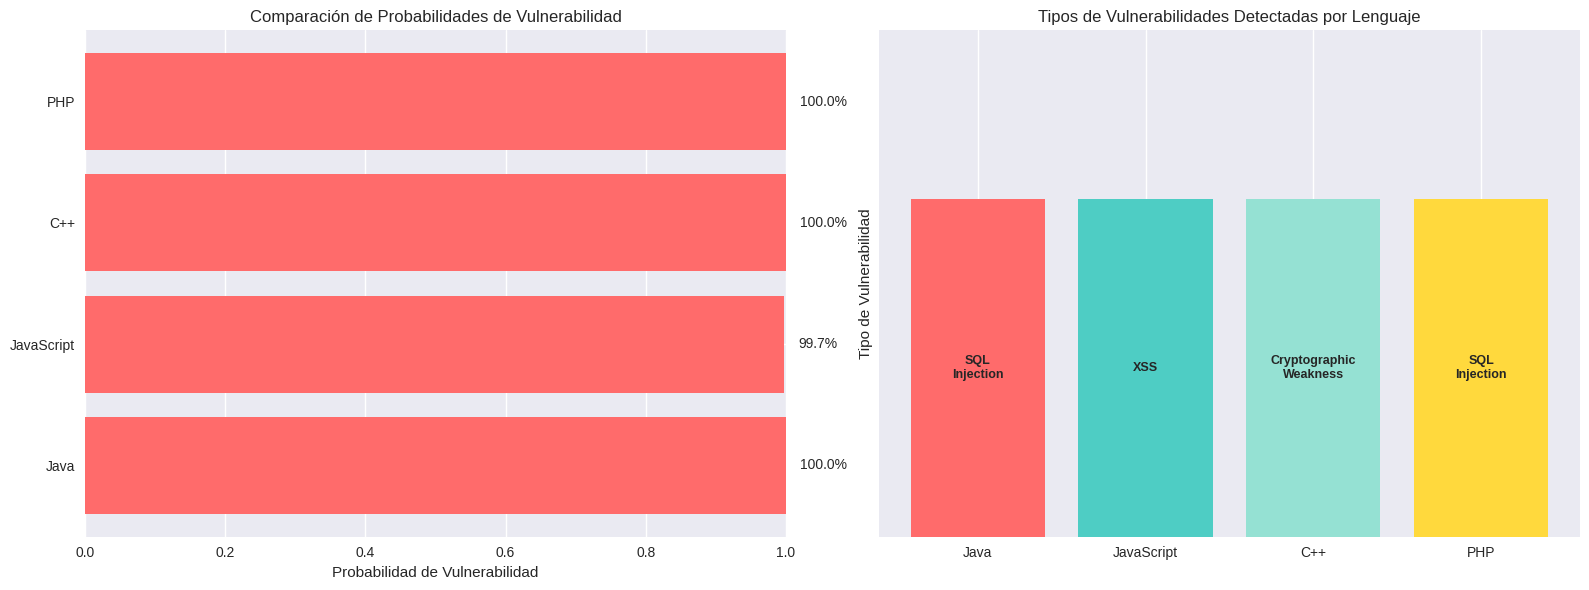


✅ Análisis completo de 4 commits en diferentes lenguajes finalizado
🎯 Vulnerabilidades identificadas:
   • Java: SQL_Injection
   • JavaScript: XSS
   • C++: Cryptographic_Weakness
   • PHP: SQL_Injection


In [ ]:
# Predicción para commit en PHP (Command Injection)
print("🎯 PREDICCIÓN PARA COMMIT EN PHP - COMMAND INJECTION")
print("=" * 50)

# Definir características de un commit en PHP con posible Command Injection
php_commit = {
    'language': 'PHP',
    'lines_added': 95,
    'lines_deleted': 22,
    'files_changed': 3,
    'cyclomatic_complexity': 19,
    'has_input_validation': 0,  # Sin validación de entrada
    'has_escape_functions': 0,  # Sin funciones de escape
    'has_raw_queries': 1,  # Comandos del sistema sin sanitizar
    'has_string_concatenation': 1,  # Concatenación directa de comandos
    'has_inner_html': 0,
    'developer_experience': 1.5,
    'previous_vulnerabilities': 3,
    'change_size': 117,
    'risk_factor': 0.585
}

# Realizar predicción
php_prediction = predict_commit_security(
    best_binary_model,
    best_multi_model,
    best_label_encoder,
    php_commit
)

print("\n📋 CARACTERÍSTICAS DEL COMMIT PHP:")
print(f"  Lenguaje: {php_commit['language']}")
print(f"  Líneas añadidas: {php_commit['lines_added']}")
print(f"  Líneas eliminadas: {php_commit['lines_deleted']}")
print(f"  Archivos modificados: {php_commit['files_changed']}")
print(f"  Complejidad ciclomática: {php_commit['cyclomatic_complexity']}")
print(f"  Validación de entrada: {'Sí' if php_commit['has_input_validation'] else 'No'}")
print(f"  Funciones de escape: {'Sí' if php_commit['has_escape_functions'] else 'No'}")
print(f"  Comandos del sistema: {'Sí' if php_commit['has_raw_queries'] else 'No'}")
print(f"  Experiencia del desarrollador: {php_commit['developer_experience']} años")

print("\n🔍 RESULTADOS DE LA PREDICCIÓN:")
print(f"  ⚠️  Es vulnerable: {php_prediction['is_vulnerable']}")
print(f"  📊 Probabilidad de vulnerabilidad: {php_prediction['vulnerability_probability']:.2%}")
print(f"  🎯 Tipo de vulnerabilidad: {php_prediction['vulnerability_type']}")
print(f"  ✅ Confianza en el tipo: {php_prediction['vulnerability_type_confidence']:.2%}")
print(f"  🚦 Nivel de riesgo: {php_prediction['risk_level']}")

print("\n📈 TOP 5 PROBABILIDADES POR TIPO DE VULNERABILIDAD:")
for i, (vuln_type, prob) in enumerate(sorted(php_prediction['all_probabilities'].items(),
                                             key=lambda x: x[1], reverse=True)[:5], 1):
    print(f"  {i}. {vuln_type}: {prob:.2%}")

print("\n💡 RECOMENDACIONES ESPECÍFICAS PARA PHP:")
if php_prediction['is_vulnerable']:
    print(f"  🚨 Este commit muestra señales de {php_prediction['vulnerability_type']}")
    print("  ⚠️  Se recomienda revisión de seguridad inmediata")
    print("  🔒 Evitar funciones peligrosas: exec(), shell_exec(), system(), passthru()")
    print("  ✅ Usar escapeshellarg() y escapeshellcmd() para sanitizar entrada")
    print("  🛡️  Implementar lista blanca de comandos permitidos")
    print("  📋 Validar y filtrar toda entrada del usuario")
    print("  🔍 Usar librerías específicas en lugar de comandos del sistema")
else:
    print("  ✅ El commit parece seguro")
    print("  📝 Continuar con buenas prácticas de seguridad en PHP")

# Tabla comparativa final de los 4 commits
print("\n" + "=" * 80)
print("📊 COMPARACIÓN GENERAL DE TODOS LOS COMMITS ANALIZADOS")
print("=" * 80)

comparison_all = pd.DataFrame({
    'Lenguaje': ['Java', 'JavaScript', 'C++', 'PHP'],
    'Vulnerabilidad': [
        java_prediction['vulnerability_type'],
        javascript_prediction['vulnerability_type'],
        cpp_prediction['vulnerability_type'],
        php_prediction['vulnerability_type']
    ],
    'Probabilidad': [
        f"{java_prediction['vulnerability_probability']:.2%}",
        f"{javascript_prediction['vulnerability_probability']:.2%}",
        f"{cpp_prediction['vulnerability_probability']:.2%}",
        f"{php_prediction['vulnerability_probability']:.2%}"
    ],
    'Riesgo': [
        java_prediction['risk_level'],
        javascript_prediction['risk_level'],
        cpp_prediction['risk_level'],
        php_prediction['risk_level']
    ],
    'Complejidad': [
        java_commit['cyclomatic_complexity'],
        javascript_commit['cyclomatic_complexity'],
        cpp_commit['cyclomatic_complexity'],
        php_commit['cyclomatic_complexity']
    ],
    'Líneas': [
        java_commit['change_size'],
        javascript_commit['change_size'],
        cpp_commit['change_size'],
        php_commit['change_size']
    ]
})

print("\n")
print(comparison_all.to_string(index=False))

# Visualización de riesgos
print("\n📈 Generando visualización comparativa...")

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Gráfico 1: Probabilidad de vulnerabilidad por lenguaje
languages = ['Java', 'JavaScript', 'C++', 'PHP']
probabilities = [
    java_prediction['vulnerability_probability'],
    javascript_prediction['vulnerability_probability'],
    cpp_prediction['vulnerability_probability'],
    php_prediction['vulnerability_probability']
]
colors = ['#ff6b6b' if p > 0.7 else '#ffd93d' if p > 0.3 else '#6bcf7f' for p in probabilities]

ax1.barh(languages, probabilities, color=colors)
ax1.set_xlabel('Probabilidad de Vulnerabilidad')
ax1.set_title('Comparación de Probabilidades de Vulnerabilidad')
ax1.set_xlim(0, 1)
for i, (lang, prob) in enumerate(zip(languages, probabilities)):
    ax1.text(prob + 0.02, i, f'{prob:.1%}', va='center')

# Gráfico 2: Tipos de vulnerabilidad detectados
vuln_types = [
    java_prediction['vulnerability_type'],
    javascript_prediction['vulnerability_type'],
    cpp_prediction['vulnerability_type'],
    php_prediction['vulnerability_type']
]
vuln_colors = plt.cm.Set3(np.linspace(0, 1, len(set(vuln_types))))

bars = ax2.bar(languages, [1, 1, 1, 1], color=['#ff6b6b', '#4ecdc4', '#95e1d3', '#ffd93d'])
ax2.set_ylabel('Tipo de Vulnerabilidad')
ax2.set_title('Tipos de Vulnerabilidades Detectadas por Lenguaje')
ax2.set_ylim(0, 1.5)
ax2.set_yticks([])

for i, (lang, vtype) in enumerate(zip(languages, vuln_types)):
    ax2.text(i, 0.5, vtype.replace('_', '\n'), ha='center', va='center',
            fontsize=9, fontweight='bold')

plt.tight_layout()
plt.show()

print("\n✅ Análisis completo de 4 commits en diferentes lenguajes finalizado")
print("🎯 Vulnerabilidades identificadas:")
print(f"   • Java: {java_prediction['vulnerability_type']}")
print(f"   • JavaScript: {javascript_prediction['vulnerability_type']}")
print(f"   • C++: {cpp_prediction['vulnerability_type']}")
print(f"   • PHP: {php_prediction['vulnerability_type']}")